In [ ]:
#Importing required libraries
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import numpy as np
import pandas as pd
import os
from tensorflow.keras.utils import to_categorical
from glob import glob

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#!unzip /content/drive/MyDrive/Study/Year4/Advanced_DS/Project/HAM10000_images_part_1 -d /content/drive/MyDrive/Study/Year4/Advanced_DS/Project/
#!unzip /content/drive/MyDrive/Study/Year4/Advanced_DS/Project/HAM10000_images_part_2 -d /content/drive/MyDrive/Study/Year4/Advanced_DS/Project/

In [ ]:
#Loading the dataset
df = pd.read_csv('/content/drive/MyDrive/Study/Year4/Advanced_DS/Project/HAM10000_metadata.csv')

#Inspecting first 5 rows of the dataset
df.head()

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

In [ ]:
df.shape

(10015, 7)

## Handling Null/Missing Values

In [ ]:
#Inspecting null values
df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

As we can see there are 57 null values in the age column so we will use mean imputation to replace these null values.

In [ ]:
#Mean imputation of null values in age column
df['age'].fillna(int(df['age'].mean()),inplace=True)

In [ ]:
#Now number of nulls is 0 in each column
df.isnull().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

In [ ]:
df["age"].value_counts()

45.0    1299
50.0    1187
55.0    1009
40.0     985
60.0     803
70.0     756
35.0     753
65.0     731
75.0     618
30.0     464
80.0     404
85.0     290
25.0     247
20.0     169
5.0       86
15.0      77
51.0      57
10.0      41
0.0       39
Name: age, dtype: int64

In [ ]:
df['dx'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

There is a age with value 0 and sex with value 'unknown', therefore, we are only keeping rows where age != 0 and sex != unknown

In [ ]:
#Subsetting the data to only keep age != 0 and sex != unknown
df_clean= df[df['age'] != 0]
df_clean= df_clean[df_clean['sex'] != 'unknown']

In [ ]:
df_clean["dx"].value_counts()

nv       6630
mel      1113
bkl      1084
bcc       514
akiec     327
vasc      138
df        115
Name: dx, dtype: int64

As we can see, there is a reduction in number of observations for nv, bkl, and vasc. However, the reduction for the minority class, vasc is not a lot (only 4) and for the class with the highest samples, nv is the most, and class with the 3rd highest samples nv is the second most, we believe it is fine to proceed with a subset of the data.

## Resizing the images

In [ ]:
#Lesion dictionary
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

#Lesion Dictionary categorical codes
lesion_code_dict = {
    'nv': 0,
    'mel': 1,
    'bkl': 2,
    'bcc': 3,
    'akiec': 4,
    'vasc': 5,
    'df': 6}

#Base dictionary
base_skin_dir = '/content/drive/MyDrive/Study/Year4/Advanced_DS/Project/'
folders = ['HAM10000_images_part_1','HAM10000_images_part_2']

# Merge images from both folders into one directory and find the images based on the image_id
imageid_path_dict = {
    os.path.splitext(os.path.basename(x))[0] : x
    for folder in folders
    for x in glob(os.path.join(base_skin_dir, folder, '*.jpg'))
}

In [ ]:
#map image_id to the dictionary and store it in a new path column
df_clean['path'] = df_clean['image_id'].map(imageid_path_dict.get)

#Store the full form of a lesion in a new column, cell type
df_clean['cell_type'] = df_clean['dx'].map(lesion_type_dict.get)

#Categorically encode the different lesion types (0-6)
df_clean['cell_type_idx'] = df_clean['dx'].map(lesion_code_dict.get)

df_clean.head()

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                                path  \
0  /content/drive/MyDrive/Study/Year4/Advanced_DS...   
1  /content/drive/MyDrive/Study/Year4/Advanced_DS...   
2  /content/drive/MyDrive/Study/Year4/Advanced_DS...   
3  /content/drive/MyDrive/Study/Year4/Advanced_DS...   
4  /content/drive/MyDrive/Study/Year4/Advanced_DS...   

                        cell_type  cell_type_idx  
0  Benign keratosis-like lesions               2  
1  Benign keratosis-like lesions               2  
2  Benign keratosis-like lesions               2  
3  Benign keratosis-like lesions               2  
4  Benign keratosis-like lesions               2

In [ ]:
df_clean['path'][0]

'/content/drive/MyDrive/Study/Year4/Advanced_DS/Project/HAM10000_images_part_1/ISIC_0027419.jpg'

In [ ]:
df_clean

lesion_id      image_id     dx dx_type   age     sex localization  \
0      HAM_0000118  ISIC_0027419    bkl   histo  80.0    male        scalp   
1      HAM_0000118  ISIC_0025030    bkl   histo  80.0    male        scalp   
2      HAM_0002730  ISIC_0026769    bkl   histo  80.0    male        scalp   
3      HAM_0002730  ISIC_0025661    bkl   histo  80.0    male        scalp   
4      HAM_0001466  ISIC_0031633    bkl   histo  75.0    male          ear   
...            ...           ...    ...     ...   ...     ...          ...   
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen   
10011  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male      abdomen   
10012  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male      abdomen   
10013  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male         face   
10014  HAM_0003521  ISIC_0032258    mel   histo  70.0  female         back   

                                                    path  \
0      /content/drive/MyDrive/Study/Year4/Advanced_DS...   
1      /content/drive/MyDrive/Study/Year4/Advanced_DS...   
2      /content/drive/MyDrive/Study/Year4/Advanced_DS...   
3      /content/drive/MyDrive/Study/Year4/Advanced_DS...   
4      /content/drive/MyDrive/Study/Year4/Advanced_DS...   
...                                                  ...   
10010  /content/drive/MyDrive/Study/Year4/Advanced_DS...   
10011  /content/drive/MyDrive/Study/Year4/Advanced_DS...   
10012  /content/drive/MyDrive/Study/Year4/Advanced_DS...   
10013  /content/drive/MyDrive/Study/Year4/Advanced_DS...   
10014  /content/drive/MyDrive/Study/Year4/Advanced_DS...   

                            cell_type  cell_type_idx  
0      Benign keratosis-like lesions               2  
1      Benign keratosis-like lesions               2  
2      Benign keratosis-like lesions               2  
3      Benign keratosis-like lesions               2  
4      Benign keratosis-like lesions               2  
...                               ...            ...  
10010               Actinic keratoses              4  
10011               Actinic keratoses              4  
10012               Actinic keratoses              4  
10013               Actinic keratoses              4  
10014                        Melanoma              1  

[9921 rows x 10 columns]

In [ ]:
#Resizing the images to 100x125 and normalizing the pixel values to between 0-1
df_clean['image'] = df_clean['path'].map(lambda x: np.asarray(Image.open(x).resize((125,100))))

In [ ]:
df_clean.head()

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                                path  \
0  /content/drive/MyDrive/Study/Year4/Advanced_DS...   
1  /content/drive/MyDrive/Study/Year4/Advanced_DS...   
2  /content/drive/MyDrive/Study/Year4/Advanced_DS...   
3  /content/drive/MyDrive/Study/Year4/Advanced_DS...   
4  /content/drive/MyDrive/Study/Year4/Advanced_DS...   

                        cell_type  cell_type_idx  \
0  Benign keratosis-like lesions               2   
1  Benign keratosis-like lesions               2   
2  Benign keratosis-like lesions               2   
3  Benign keratosis-like lesions               2   
4  Benign keratosis-like lesions               2   

                                               image  
0  [[[189, 152, 194], [192, 156, 198], [191, 154,...  
1  [[[24, 13, 22], [24, 14, 22], [24, 14, 26], [2...  
2  [[[186, 127, 135], [189, 133, 145], [192, 135,...  
3  [[[24, 11, 17], [24, 11, 20], [30, 15, 25], [4...  
4  [[[131, 88, 110], [142, 97, 120], [152, 107, 1...

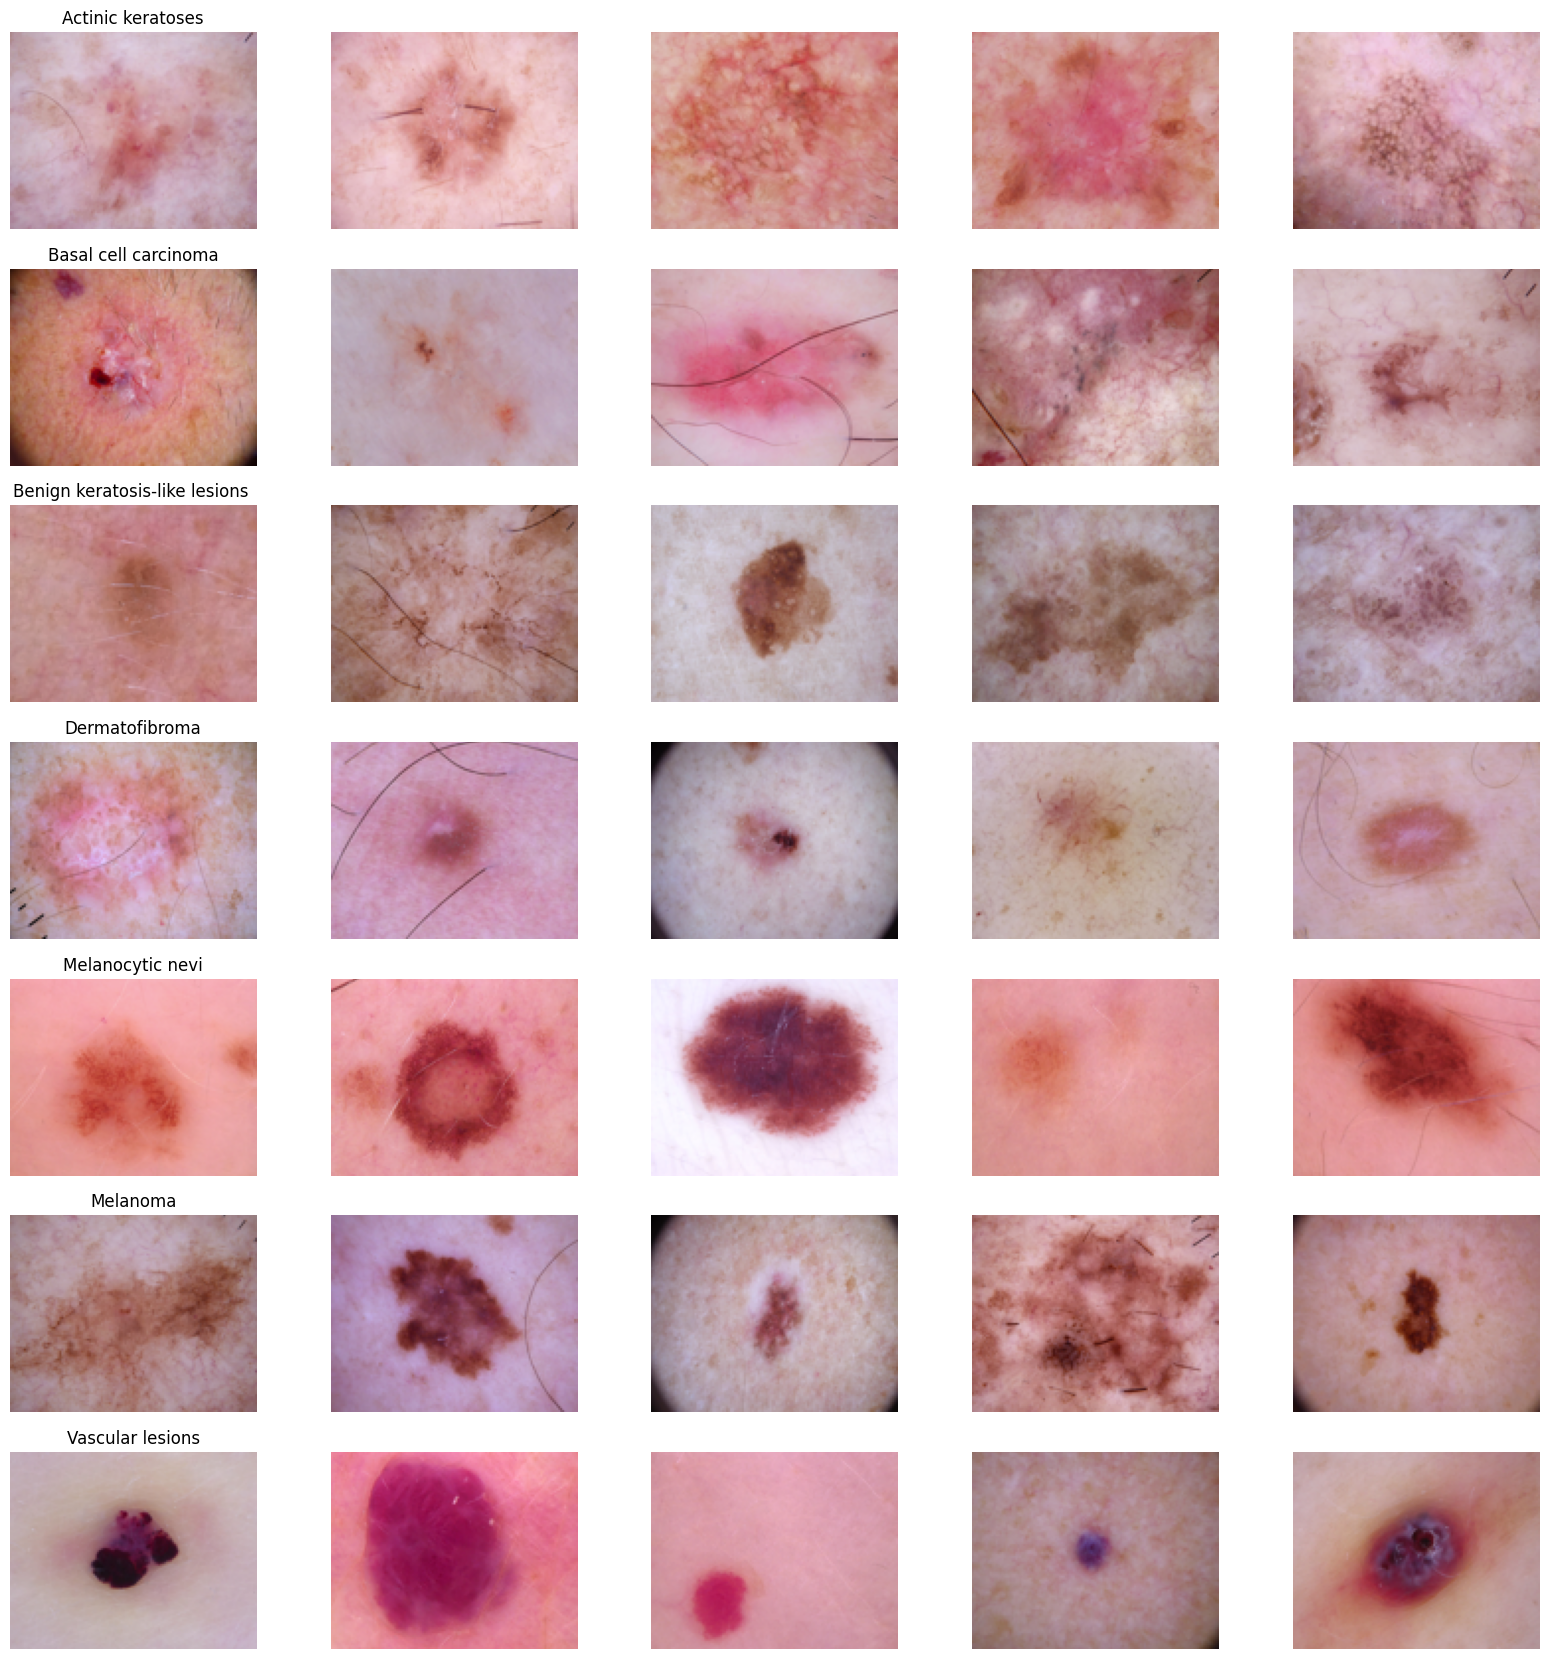

In [ ]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs,
                                         df_clean.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

## Fixing Data Imbalance

<Axes: title={'center': 'CELL TYPE'}, xlabel='Lesion Type', ylabel='Count'>

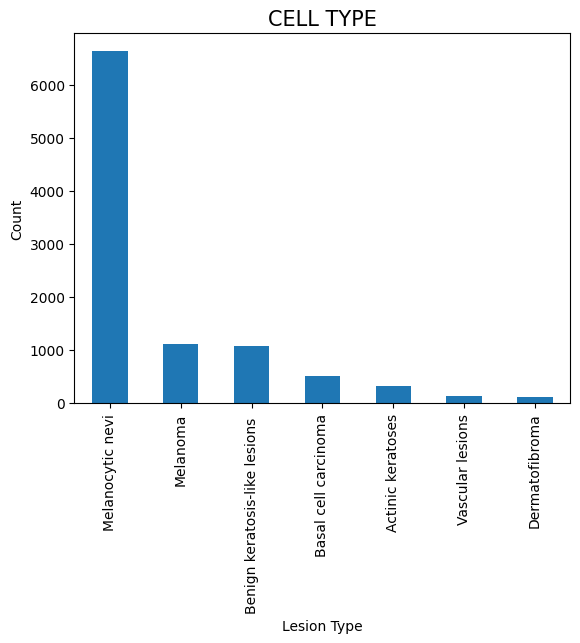

In [ ]:

plt.title("CELL TYPE",fontsize=15)
plt.ylabel("Count")
plt.xlabel("Lesion Type")
df_clean['cell_type'].value_counts().plot.bar()

From the distribution above, we can see that the dataset is highly imbalanced. Did not use random oversampling because then then there will be multiple duplicates of the minority class images, which may cause our model to overfit.

In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from collections import Counter

In [ ]:
#Getting our train, test and validation sets

def train_test_df(df):
    features=df.drop(columns=['cell_type_idx'],axis=1)
    target=df['cell_type_idx']

    #Split train and test 80-20 split used
    x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=123)

    #We won't normalize right now because we are using GridSearchCV with pipeline
    x_train = np.asarray(x_train_o['image'].tolist())
    x_test = np.asarray(x_test_o['image'].tolist())

    # Perform one-hot encoding on the labels
    y_train = to_categorical(y_train_o, num_classes = 7)
    y_test = to_categorical(y_test_o, num_classes = 7)

    #Splitting training into Train and Validatation sets 90-10
    x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1,random_state=123)

    #Reshaping the Images into 3 channels (RGB)
    x_train = x_train.reshape(x_train.shape[0], *(100, 125, 3))
    x_test = x_test.reshape(x_test.shape[0], *(100, 125, 3))
    x_validate = x_validate.reshape(x_validate.shape[0], *(100, 125, 3))

    return x_train,x_validate,x_test,y_train,y_validate,y_test

x_train,x_validate,x_test,y_train,y_validate,y_test = train_test_df(df_clean) #change to df_clean

## Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Data augmentation to prevent overfitting
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.12,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.12,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

datagen.fit(x_train)

## Baseline: Without Data Augmentation



## Compared to With Data Augmentation


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the pre-trained DenseNet-201 model (weights pre-trained on ImageNet)
base_model = DenseNet201(weights='imagenet', include_top=False)

# Freeze some layers in the base model
num_layers_to_freeze = 95  # Choose the number of layers you want to freeze
for layer in base_model.layers[:num_layers_to_freeze]:
    layer.trainable = False

# Redefining FC Layer since include_top is set to False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x) #Now predicts 7 classes

# Create the final model
model_dense = Model(inputs=base_model.input, outputs=predictions)

# Learning Rate Scheduler
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,   # Adjust decay_steps
    decay_rate=0.9       # Adjust decay_rate
)
optimizer = Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=False)

model_dense.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

74836368/74836368 [==============================] - 1s 0us/step


In [ ]:
# Fit the model
epochs = 50
batch_size = 60

history = model_dense.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                                    epochs=epochs, verbose=1, steps_per_epoch=x_train.shape[0] // batch_size,
                                    callbacks=[learning_rate_reduction,early_stopping], validation_data=(x_validate, y_validate))


# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

<ipython-input-26-9eedd4afbba5>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_dense.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),


Epoch 1/50


In [ ]:
import plotly.graph_objects as go

In [ ]:
# Function to plot the confusion matrix with Plotly
import plotly.graph_objects as go
def plot_confusion_matrix(cm, classes, normalize=False):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        colorscale = 'Plasma'
    else:
        colorscale = 'Magma_r'  # Reversed 'Magma' colorscale for non-normalized matrix

    annotations = []
    for i in range(len(classes)):
        for j in range(len(classes)):
            annotations.append(
                {
                    'x': classes[j],
                    'y': classes[i],
                    'text': str(cm[i, j]),
                    'showarrow': False,
                    'font': {'color': 'red' if cm[i, j] > 0.5 else 'black'}
                }
            )

    fig = go.Figure(data=go.Heatmap(
        z=cm,
        x=list(classes),
        y=list(classes),
        colorscale=colorscale,
        colorbar=dict(title='Normalized' if normalize else 'Count'),
        showscale=True,
        hoverinfo='z'
    ))

    fig.update_layout(
        title='Confusion Matrix',
        xaxis=dict(title='Predicted label'),
        yaxis=dict(title='True label'),
        annotations=annotations
    )

    if normalize:
        fig.update_layout(title_text='Normalized Confusion Matrix')
    else:
        fig.update_layout(title_text='Confusion Matrix (Counts)')

    fig.show()

In [ ]:
#Printing classification report
from sklearn.metrics import confusion_matrix, classification_report

classes = range(7)

# Y_true (true labels) and Y_pred_classes (predicted labels) Evaluating performance on test set
Y_pred = model_dense.predict(x_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(y_test, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# Plot the confusion matrix with the new colorscale
plot_confusion_matrix(confusion_mtx, classes=classes, normalize=False)

report = classification_report(Y_true, Y_pred_classes)
print(f"Classification Report for <<DenseNet201>> : ")
print(report)

### Resnet Without Data Augmentation

## Now Introducing with Input Normalization vs Without Input Normalization

In [ ]:
#featurewise_center=True,featurewise_std_normalization=True
#Data augmentation to prevent overfitting
datagen = ImageDataGenerator(
        featurewise_center=True,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=True,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.12,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.12,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

datagen.fit(x_train)



In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the pre-trained DenseNet-201 model (weights pre-trained on ImageNet)
base_model = DenseNet201(weights='imagenet', include_top=False)

# Freeze some layers in the base model
num_layers_to_freeze = 95  # Choose the number of layers you want to freeze
for layer in base_model.layers[:num_layers_to_freeze]:
    layer.trainable = False

# Redefining FC Layer since include_top is set to False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x) #Now predicts 7 classes

# Create the final model
model_dense = Model(inputs=base_model.input, outputs=predictions)

# Learning Rate Scheduler
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,   # Adjust decay_steps
    decay_rate=0.9       # Adjust decay_rate
)
optimizer = Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=False)

model_dense.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

<ipython-input-34-cd74e925ed5f>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_dense.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),


Epoch 1/50
119/119 [==============================] - 175s 480ms/step - loss: 1.4966 - accuracy: 0.6614 - val_loss: 1543421.6250 - val_accuracy: 0.6776 - lr: 0.0100
Epoch 2/50
119/119 [==============================] - 40s 338ms/step - loss: 0.8787 - accuracy: 0.6946 - val_loss: 12294.3594 - val_accuracy: 0.6776 - lr: 0.0100
Epoch 3/50
119/119 [==============================] - 43s 361ms/step - loss: 0.7803 - accuracy: 0.7167 - val_loss: 10404413.0000 - val_accuracy: 0.6776 - lr: 0.0100
Epoch 4/50
119/119 [==============================] - ETA: 0s - loss: 0.7263 - accuracy: 0.7340
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.004975039046257734.
119/119 [==============================] - 40s 335ms/step - loss: 0.7263 - accuracy: 0.7340 - val_loss: 385891.2500 - val_accuracy: 0.6776 - lr: 0.0100
Epoch 5/50
119/119 [==============================] - 40s 337ms/step - loss: 0.6807 - accuracy: 0.7528 - val_loss: 882082.6875 - val_accuracy: 0.6776 - lr: 0.0099
Epoch 6/50
119/119 [==

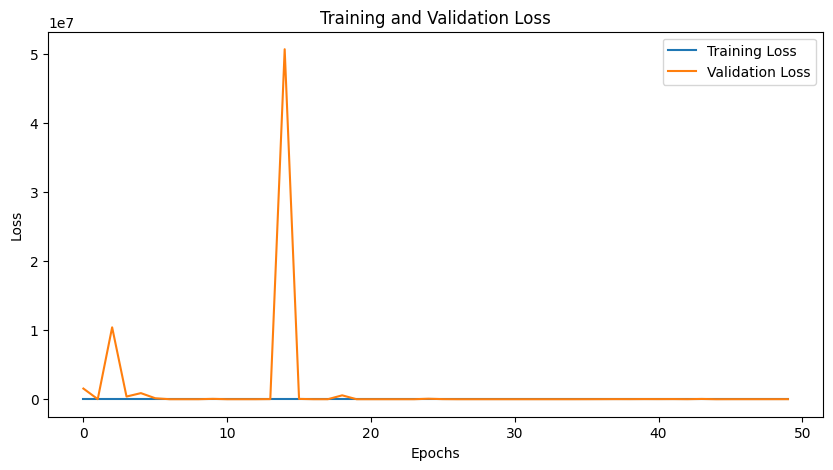

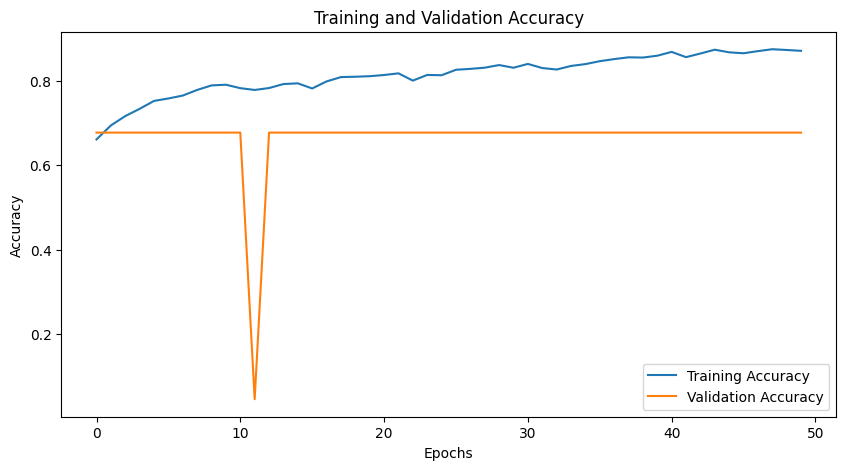

In [ ]:
epochs = 50
batch_size = 60

history = model_dense.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                                    epochs=epochs, verbose=1, steps_per_epoch=x_train.shape[0] // batch_size,
                                    callbacks=[learning_rate_reduction,early_stopping], validation_data=(x_validate, y_validate))


# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [ ]:
#Printing classification report
import plotly.graph_objects as go

from sklearn.metrics import confusion_matrix, classification_report

classes = range(7)

# Y_true (true labels) and Y_pred_classes (predicted labels) Evaluating performance on test set
Y_pred = model_dense.predict(x_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(y_test, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# Plot the confusion matrix with the new colorscale
plot_confusion_matrix(confusion_mtx, classes=classes, normalize=False)

report = classification_report(Y_true, Y_pred_classes)
print(f"Classification Report for <<DenseNet201>> : ")
print(report)

63/63 [==============================] - 3s 54ms/step


Classification Report for <<DenseNet201>> : 
              precision    recall  f1-score   support

           0       0.66      1.00      0.80      1313
           1       0.00      0.00      0.00       238
           2       0.00      0.00      0.00       222
           3       0.00      0.00      0.00       100
           4       0.00      0.00      0.00        66
           5       0.00      0.00      0.00        24
           6       0.00      0.00      0.00        22

    accuracy                           0.66      1985
   macro avg       0.09      0.14      0.11      1985
weighted avg       0.44      0.66      0.53      1985



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



## Build Off Which One Is Better + Batch Normalization vs w/o Batch Normalization

In [ ]:
#featurewise_center=True,featurewise_std_normalization=True
#Data augmentation to prevent overfitting
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.12,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.12,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

datagen.fit(x_train)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [ ]:
##Batch normalization

import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the pre-trained DenseNet-201 model (weights pre-trained on ImageNet)
base_model = DenseNet201(weights='imagenet', include_top=False)

# Freeze some layers in the base model
num_layers_to_freeze = 95  # Choose the number of layers you want to freeze
for layer in base_model.layers[:num_layers_to_freeze]:
    layer.trainable = False

# Redefining FC Layer since include_top is set to False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)  # Add BatchNormalization layer for better convergence
x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = BatchNormalization()(x)  # Add BatchNormalization layer for better convergence
predictions = Dense(7, activation='softmax')(x)

# Create the final model
model_dense = Model(inputs=base_model.input, outputs=predictions)

# Learning Rate Scheduler
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,   # Adjust decay_steps
    decay_rate=0.9       # Adjust decay_rate
)
optimizer = Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=False)

model_dense.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

<ipython-input-26-9eedd4afbba5>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_dense.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),


Epoch 1/50
119/119 [==============================] - 174s 448ms/step - loss: 2.4967 - accuracy: 0.6608 - val_loss: 190.2537 - val_accuracy: 0.6776 - lr: 0.0100
Epoch 2/50
119/119 [==============================] - 40s 339ms/step - loss: 1.3394 - accuracy: 0.7098 - val_loss: 265.7326 - val_accuracy: 0.4408 - lr: 0.0100
Epoch 3/50
119/119 [==============================] - 42s 354ms/step - loss: 1.5992 - accuracy: 0.7182 - val_loss: 515.0340 - val_accuracy: 0.1801 - lr: 0.0100
Epoch 4/50
119/119 [==============================] - ETA: 0s - loss: 1.2695 - accuracy: 0.7255
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.004975039046257734.
119/119 [==============================] - 40s 338ms/step - loss: 1.2695 - accuracy: 0.7255 - val_loss: 86.9640 - val_accuracy: 0.2796 - lr: 0.0100
Epoch 5/50
119/119 [==============================] - 43s 357ms/step - loss: 1.1521 - accuracy: 0.7416 - val_loss: 8.7166 - val_accuracy: 0.5756 - lr: 0.0099
Epoch 6/50
119/119 [======================

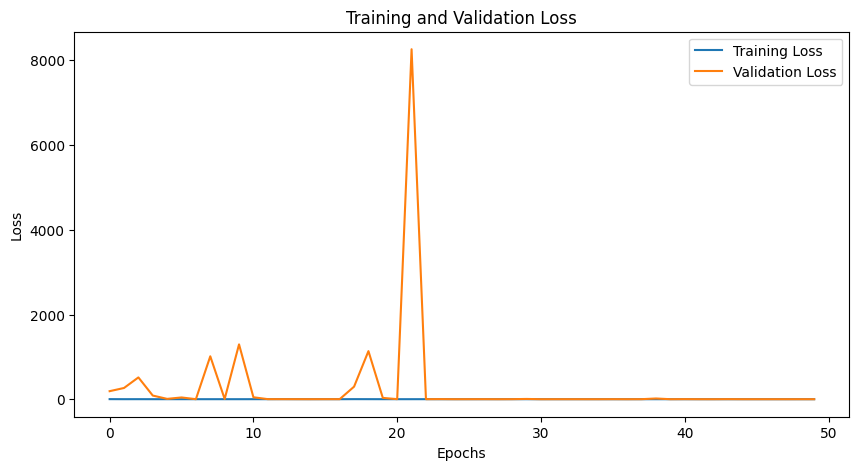

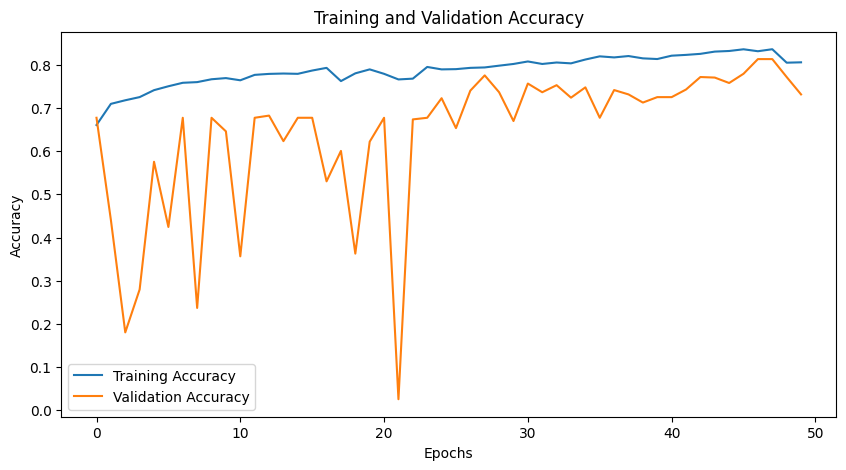

In [ ]:
# Fit the model
epochs = 50
batch_size = 60

history = model_dense.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                                    epochs=epochs, verbose=1, steps_per_epoch=x_train.shape[0] // batch_size,
                                    callbacks=[learning_rate_reduction,early_stopping], validation_data=(x_validate, y_validate))


# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [ ]:
#Printing classification report
import plotly.graph_objects as go

from sklearn.metrics import confusion_matrix, classification_report

classes = range(7)

# Y_true (true labels) and Y_pred_classes (predicted labels) Evaluating performance on test set
Y_pred = model_dense.predict(x_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(y_test, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# Plot the confusion matrix with the new colorscale
plot_confusion_matrix(confusion_mtx, classes=classes, normalize=False)

report = classification_report(Y_true, Y_pred_classes)
print(f"Classification Report for <<DenseNet201>> : ")
print(report)

63/63 [==============================] - 3s 51ms/step


Classification Report for <<DenseNet201>> : 
              precision    recall  f1-score   support

           0       0.92      0.84      0.88      1313
           1       0.41      0.78      0.53       238
           2       0.51      0.55      0.53       222
           3       0.88      0.23      0.37       100
           4       0.57      0.06      0.11        66
           5       0.59      0.96      0.73        24
           6       0.00      0.00      0.00        22

    accuracy                           0.74      1985
   macro avg       0.55      0.49      0.45      1985
weighted avg       0.78      0.74      0.74      1985



## Build Off and Add Dropout

In [ ]:
#Adding normalization and standardization to train test split
def train_test_df_normstandard(df):
    features=df.drop(columns=['cell_type_idx'],axis=1)
    target=df['cell_type_idx']
    # Create First Train and Test sets
    x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=123)
    x_train = np.asarray(x_train_o['image'].tolist())
    x_test = np.asarray(x_test_o['image'].tolist())
    #Normalization
    x_train = x_train / 255
    x_test = x_test / 255
    #The standardization is done using the training set Mean and Std. Deviation as reference
    x_train_mean = np.mean(x_train)
    x_train_std = np.std(x_train)
    x_train = (x_train - x_train_mean)/x_train_std
    x_test = (x_test - x_train_mean)/x_train_std
    # Perform one-hot encoding on the labels
    y_train = to_categorical(y_train_o, num_classes = 7)
    y_test = to_categorical(y_test_o, num_classes = 7)
    #Splitting training into Train and Validatation sets
    x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1,random_state=123)
    #Reshaping the Images into 3 channels (RGB)
    x_train = x_train.reshape(x_train.shape[0], *(100, 125, 3))
    x_test = x_test.reshape(x_test.shape[0], *(100, 125, 3))
    x_validate = x_validate.reshape(x_validate.shape[0], *(100, 125, 3))
    return x_train,x_validate,x_test,y_train,y_validate,y_test
x_train,x_validate,x_test,y_train,y_validate,y_test = train_test_df_normstandard(df_clean) #change to df_clean

In [ ]:
#featurewise_center=True,featurewise_std_normalization=True
#Data augmentation to prevent overfitting
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.12,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.12,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

datagen.fit(x_train)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [ ]:
##Batch normalization

import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the pre-trained DenseNet-201 model (weights pre-trained on ImageNet)
base_model = DenseNet201(weights='imagenet', include_top=False)

# Freeze some layers in the base model
num_layers_to_freeze = 95  # Choose the number of layers you want to freeze
for layer in base_model.layers[:num_layers_to_freeze]:
    layer.trainable = False

# Redefining FC Layer since include_top is set to False
x = base_model.output
x = GlobalAveragePooling2D()(x)
#x = BatchNormalization()(x)  # Add BatchNormalization layer for better convergence
x = BatchNormalization()(x)  # Add BatchNormalization layer for better convergence
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
predictions = Dense(7, activation='softmax')(x)

# Create the final model
model_dense = Model(inputs=base_model.input, outputs=predictions)

# Learning Rate Scheduler
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,   # Adjust decay_steps
    decay_rate=0.9       # Adjust decay_rate
)
optimizer = Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=False)

model_dense.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

<ipython-input-28-9eedd4afbba5>:5: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/50
119/119 [==============================] - 160s 432ms/step - loss: 3.4143 - accuracy: 0.6487 - val_loss: 10061147.0000 - val_accuracy: 0.6725 - lr: 0.0100
Epoch 2/50
119/119 [==============================] - 43s 358ms/step - loss: 1.2984 - accuracy: 0.6838 - val_loss: 1312.0662 - val_accuracy: 0.6776 - lr: 0.0100
Epoch 3/50
119/119 [==============================] - 42s 347ms/step - loss: 1.2392 - accuracy: 0.6966 - val_loss: 78.3166 - val_accuracy: 0.6977 - lr: 0.0100
Epoch 4/50
119/119 [==============================] - 40s 338ms/step - loss: 2.1978 - accuracy: 0.6966 - val_loss: 69.3216 - val_accuracy: 0.6020 - lr: 0.0100
Epoch 5/50
119/119 [==============================] - 41s 348ms/step - loss: 1.3146 - accuracy: 0.7071 - val_loss: 175.3067 - val_accuracy: 0.6851 - lr: 0.0099
Epoch 6/50
119/119 [==============================] - ETA: 0s - loss: 1.1541 - accuracy: 0.7259
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.004962579347193241.
119/119 [===============

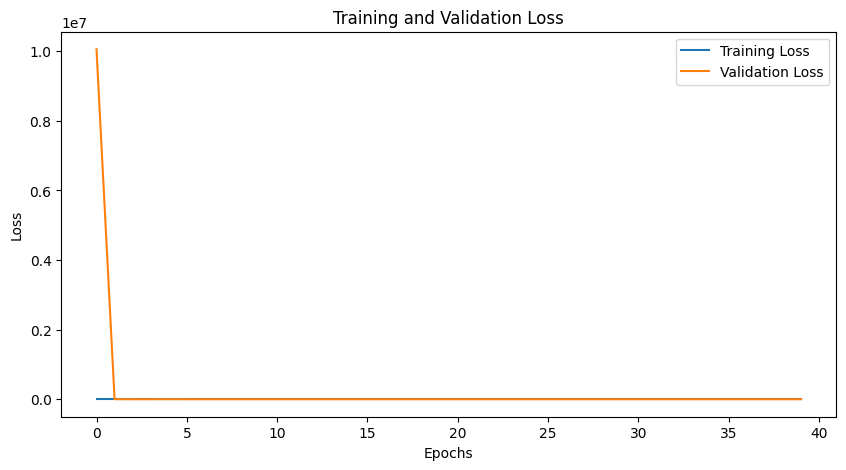

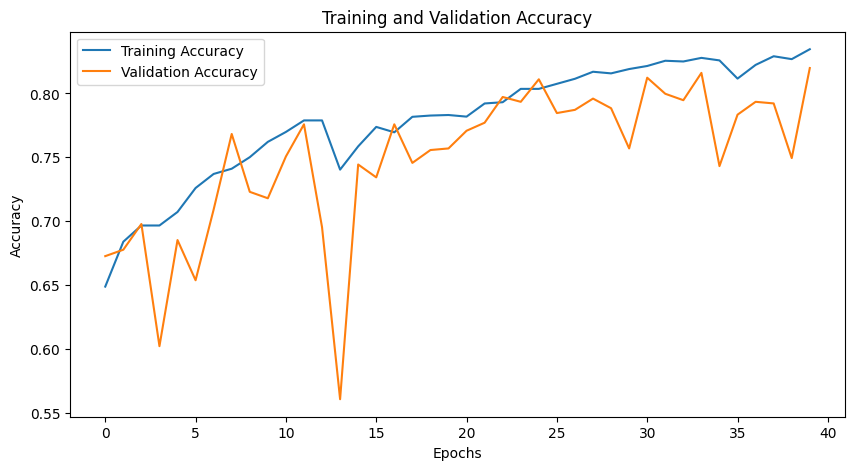

In [ ]:
# Fit the model
epochs = 50
batch_size = 60

history = model_dense.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                                    epochs=epochs, verbose=1, steps_per_epoch=x_train.shape[0] // batch_size,
                                    callbacks=[learning_rate_reduction,early_stopping], validation_data=(x_validate, y_validate))


# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [ ]:
#Printing classification report
import plotly.graph_objects as go

from sklearn.metrics import confusion_matrix, classification_report

classes = range(7)

# Y_true (true labels) and Y_pred_classes (predicted labels) Evaluating performance on test set
Y_pred = model_dense.predict(x_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(y_test, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# Plot the confusion matrix with the new colorscale
plot_confusion_matrix(confusion_mtx, classes=classes, normalize=False)

report = classification_report(Y_true, Y_pred_classes)
print(f"Classification Report for <<DenseNet201>> with input normalization, data augmentation, batch normalization, and drop out: ")
print(report)

63/63 [==============================] - 3s 51ms/step


Classification Report for <<DenseNet201>> with input normalization, data augmentation, batch normalization, and drop out: 
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      1313
           1       0.63      0.47      0.54       238
           2       0.62      0.64      0.63       222
           3       0.65      0.63      0.64       100
           4       0.49      0.53      0.51        66
           5       0.81      0.92      0.86        24
           6       0.00      0.00      0.00        22

    accuracy                           0.81      1985
   macro avg       0.58      0.59      0.58      1985
weighted avg       0.79      0.81      0.80      1985



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



## Hyperparamater Tuning using GridSearchCV

1. Different Learning Rates but with same Learning Rate Scheduler
3. Different Optimizer
4. Different Activation Function
5. Instead of optimizing accuracy, we would want to optimize F1 score
6. Vary Number of Layers to Freeze
7. Vary Dropout Rate


In [ ]:
#Adding normalization and standardization to train test split
def train_test_df_normstandard(df):
    features=df.drop(columns=['cell_type_idx'],axis=1)
    target=df['cell_type_idx']
    # Create First Train and Test sets
    x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=123)
    x_train = np.asarray(x_train_o['image'].tolist())
    x_test = np.asarray(x_test_o['image'].tolist())
    #Normalization
    x_train = x_train / 255
    x_test = x_test / 255
    #The standardization is done using the training set Mean and Std. Deviation as reference
    x_train_mean = np.mean(x_train)
    x_train_std = np.std(x_train)
    x_train = (x_train - x_train_mean)/x_train_std
    x_test = (x_test - x_train_mean)/x_train_std
    # Perform one-hot encoding on the labels
    y_train = to_categorical(y_train_o, num_classes = 7)
    y_test = to_categorical(y_test_o, num_classes = 7)
    #Splitting training into Train and Validatation sets
    x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1,random_state=123)
    #Reshaping the Images into 3 channels (RGB)
    x_train = x_train.reshape(x_train.shape[0], *(100, 125, 3))
    x_test = x_test.reshape(x_test.shape[0], *(100, 125, 3))
    x_validate = x_validate.reshape(x_validate.shape[0], *(100, 125, 3))
    return x_train,x_validate,x_test,y_train,y_validate,y_test
x_train,x_validate,x_test,y_train,y_validate,y_test = train_test_df_normstandard(df_clean) #change to df_clean



In [ ]:
#featurewise_center=True,featurewise_std_normalization=True
#Data augmentation to prevent overfitting
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.12,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.12,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

datagen.fit(x_train)

In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.8/252.8 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.6 MB/s eta 0:00:00


In [ ]:
import wandb

wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
sweep_config = {
    'method': 'random'
    }

metric = {
    'name': 'loss',
    'goal': 'minimize'
    }

sweep_config['metric'] = metric

parameters_dict = {
    'optimizer': {
        'values': ['adam', 'sgd']
        },
    'fc_layer_size': {
        'values': [128, 256, 512]
        },
    'dropout': {
        'distribution': 'uniform',
        'min': 0,
        'max': 0.5
        },
    'learning_rate': {
        # a flat distribution between 0 and 0.1
        'distribution': 'uniform',
        'min': 0.001,
        'max': 0.1

        #'values': [0.1, 0.05, 0.01, 0.005, 0.001]
      },
    'freeze_layers': {
        'values': [50, 80, 100, 150]
        },
    'patience': {
        'values': [5, 10, 15]
        },
    'batch_size': {
        # a flat distribution between 0 and 0.1
        'distribution': 'int_uniform',
        'min': 20,
        'max': 100
     },
    'epoch': {
        # a flat distribution between 0 and 0.1
        'distribution': 'int_uniform',
        'min': 20,
        'max': 100
     }
    }
#batch size? epoch

sweep_config['parameters'] = parameters_dict

In [ ]:
import pprint

pprint.pprint(sweep_config)

{'method': 'random',
 'metric': {'goal': 'minimize', 'name': 'loss'},
 'parameters': {'batch_size': {'distribution': 'int_uniform',
                               'max': 100,
                               'min': 20},
                'dropout': {'distribution': 'uniform', 'max': 0.5, 'min': 0},
                'epoch': {'distribution': 'int_uniform', 'max': 100, 'min': 20},
                'fc_layer_size': {'values': [128, 256, 512]},
                'freeze_layers': {'values': [50, 80, 100, 150]},
                'learning_rate': {'distribution': 'uniform',
                                  'max': 0.1,
                                  'min': 0.001},
                'optimizer': {'values': ['adam', 'sgd']},
                'patience': {'values': [5, 10, 15]}}}


In [ ]:
sweep_id = wandb.sweep(sweep_config, project="dense_random")

Create sweep with ID: 2w8c6aye
Sweep URL: https://wandb.ai/hannahphung/dense_random/sweeps/2w8c6aye


In [ ]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torchvision import datasets, transforms

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam,SGD

def build_network(fc_layer_size, dropout, freeze_layers):
    # Load the pre-trained DenseNet-201 model (weights pre-trained on ImageNet)
    base_model = DenseNet201(weights='imagenet', include_top=False)

    # Freeze some layers in the base model
    num_layers_to_freeze = freeze_layers  # Choose the number of layers you want to freeze
    for layer in base_model.layers[:num_layers_to_freeze]:
        layer.trainable = False

    # Redefining FC Layer since include_top is set to False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    #x = BatchNormalization()(x)  # Add BatchNormalization layer for better convergence
    x = Dropout(dropout)(x)
    x = Dense(fc_layer_size, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    predictions = Dense(7, activation='softmax')(x)

    # Create the final model
    model_dense = Model(inputs=base_model.input, outputs=predictions)
    return model_dense


def build_optimizer(optimizer, learning_rate):
    # Learning Rate Scheduler
    initial_learning_rate = learning_rate
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=10000,   # Adjust decay_steps
        decay_rate=0.9       # Adjust decay_rate
    )
    if optimizer == "sgd":
        optimizer = SGD(learning_rate=lr_schedule, momentum=0.9)
    elif optimizer == "adam":
        optimizer = Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=False)
    return optimizer

In [ ]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torchvision import datasets, transforms
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(config=None):
    # Initialize a new wandb run
    with wandb.init(config=config):
        # If called by wandb.agent, as below,
        # this config will be set by Sweep Controller
        config = wandb.config

        model_dense = build_network(config.fc_layer_size, config.dropout, config.freeze_layers)
        optimizer = build_optimizer(config.optimizer, config.learning_rate)

        epochs = config.epoch
        batch_size = config.batch_size

        model_dense.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

        # Early Stopping
        early_stopping = EarlyStopping(monitor='val_loss', patience=config.patience, restore_best_weights=True)

        learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

        history = model_dense.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                                    epochs=epochs, verbose=0, steps_per_epoch=x_train.shape[0] // batch_size,
                                    callbacks=[learning_rate_reduction,early_stopping], validation_data=(x_validate, y_validate))

        avg_loss = np.mean(history.history['loss'])
        avg_val_loss = np.mean(history.history['val_loss'])

        wandb.log({"loss": avg_loss, "val_loss": avg_val_loss})

In [ ]:
wandb.agent(sweep_id, train, count=5)

wandb: Agent Starting Run: ayr360m3 with config:
wandb: 	batch_size: 23
wandb: 	dropout: 0.21438549538126167
wandb: 	epoch: 69
wandb: 	fc_layer_size: 256
wandb: 	freeze_layers: 80
wandb: 	learning_rate: 0.03929385835328364
wandb: 	optimizer: sgd
wandb: 	patience: 15
wandb: Currently logged in as: hmp3554 (hannahphung). Use `wandb login --relogin` to force relogin


74836368/74836368 [==============================] - 0s 0us/step


<ipython-input-33-2eb77cf0098d>:35: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_dense.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),



Epoch 15: ReduceLROnPlateau reducing learning rate to 0.018707770854234695.

Epoch 18: ReduceLROnPlateau reducing learning rate to 0.01852535642683506.

Epoch 25: ReduceLROnPlateau reducing learning rate to 0.01810661144554615.

Epoch 28: ReduceLROnPlateau reducing learning rate to 0.017930060625076294.

Epoch 34: ReduceLROnPlateau reducing learning rate to 0.017582103610038757.

Epoch 37: ReduceLROnPlateau reducing learning rate to 0.01741066575050354.

Epoch 40: ReduceLROnPlateau reducing learning rate to 0.01724090240895748.

Epoch 43: ReduceLROnPlateau reducing learning rate to 0.01707279123365879.

Epoch 46: ReduceLROnPlateau reducing learning rate to 0.016906319186091423.

Epoch 49: ReduceLROnPlateau reducing learning rate to 0.016741469502449036.

Epoch 52: ReduceLROnPlateau reducing learning rate to 0.016578229144215584.


wandb: Agent Starting Run: g5g0ib4x with config:
wandb: 	batch_size: 77
wandb: 	dropout: 0.23476285744007824
wandb: 	epoch: 80
wandb: 	fc_layer_size: 256
wandb: 	freeze_layers: 100
wandb: 	learning_rate: 0.05249855719913242
wandb: 	optimizer: sgd
wandb: 	patience: 15



Epoch 10: ReduceLROnPlateau reducing learning rate to 0.025996342301368713.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.02592085674405098.

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.025845589116215706.

Epoch 19: ReduceLROnPlateau reducing learning rate to 0.025770539417862892.

Epoch 22: ReduceLROnPlateau reducing learning rate to 0.025695709511637688.

Epoch 26: ReduceLROnPlateau reducing learning rate to 0.025596274062991142.

Epoch 29: ReduceLROnPlateau reducing learning rate to 0.02552194893360138.


wandb: Agent Starting Run: hcqdygur with config:
wandb: 	batch_size: 61
wandb: 	dropout: 0.4665888846145652
wandb: 	epoch: 42
wandb: 	fc_layer_size: 256
wandb: 	freeze_layers: 50
wandb: 	learning_rate: 0.08482257818026998
wandb: 	optimizer: sgd
wandb: 	patience: 10



Epoch 4: ReduceLROnPlateau reducing learning rate to 0.04220312461256981.

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.04204734042286873.

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.04163471609354019.

Epoch 18: ReduceLROnPlateau reducing learning rate to 0.041481029242277145.

Epoch 21: ReduceLROnPlateau reducing learning rate to 0.041327908635139465.


wandb: Agent Starting Run: t7ptmq65 with config:
wandb: 	batch_size: 79
wandb: 	dropout: 0.47010550770668263
wandb: 	epoch: 57
wandb: 	fc_layer_size: 256
wandb: 	freeze_layers: 80
wandb: 	learning_rate: 0.014409686404639691
wandb: 	optimizer: sgd
wandb: 	patience: 10



Epoch 10: ReduceLROnPlateau reducing learning rate to 0.007136921398341656.

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.007109902799129486.

Epoch 18: ReduceLROnPlateau reducing learning rate to 0.007082986179739237.

Epoch 21: ReduceLROnPlateau reducing learning rate to 0.007062865421175957.


wandb: Agent Starting Run: oig8u0y4 with config:
wandb: 	batch_size: 58
wandb: 	dropout: 0.1829751227861282
wandb: 	epoch: 40
wandb: 	fc_layer_size: 256
wandb: 	freeze_layers: 50
wandb: 	learning_rate: 0.09294004995048652
wandb: 	optimizer: adam
wandb: 	patience: 15



Epoch 8: ReduceLROnPlateau reducing learning rate to 0.04599121958017349.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.04581276327371597.

Epoch 22: ReduceLROnPlateau reducing learning rate to 0.0451643168926239.

Epoch 25: ReduceLROnPlateau reducing learning rate to 0.044989071786403656.

Epoch 28: ReduceLROnPlateau reducing learning rate to 0.04481450095772743.


# Ensemble model

## Class 0 vs rest

In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

model_filepath = '/content/drive/MyDrive/Study/Year4/Advanced_DS/Project/ensemble1.hdf5'

checkpoint = ModelCheckpoint(
    filepath=model_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)


In [ ]:
#Adding normalization and standardization to train test split
def train_test_df_normstandard(df):
    features=df.drop(columns=['cell_type_idx'],axis=1)
    target=df['cell_type_idx']
    # Create First Train and Test sets
    x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=123)
    x_train = np.asarray(x_train_o['image'].tolist())
    x_test = np.asarray(x_test_o['image'].tolist())
    #Normalization
    x_train = x_train / 255
    x_test = x_test / 255
    #The standardization is done using the training set Mean and Std. Deviation as reference
    x_train_mean = np.mean(x_train)
    x_train_std = np.std(x_train)
    x_train = (x_train - x_train_mean)/x_train_std
    x_test = (x_test - x_train_mean)/x_train_std
    # Perform one-hot encoding on the labels
    y_train = to_categorical(y_train_o, num_classes = 7)
    y_test = to_categorical(y_test_o, num_classes = 7)
    #Splitting training into Train and Validatation sets
    x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1,random_state=123)
    #Reshaping the Images into 3 channels (RGB)
    x_train = x_train.reshape(x_train.shape[0], *(100, 125, 3))
    x_test = x_test.reshape(x_test.shape[0], *(100, 125, 3))
    x_validate = x_validate.reshape(x_validate.shape[0], *(100, 125, 3))
    return x_train,x_validate,x_test,y_train,y_validate,y_test
x_train,x_validate,x_test,y_train,y_validate,y_test = train_test_df_normstandard(df_clean) #change to df_clean

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.12,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.12,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

datagen.fit(x_train)

In [ ]:
len(y_test)

1985

In [ ]:
# Combine all remaining classes into 1 class
def modify_y (cur_y):
  if cur_y[0] == 1:
    return [1,0]
  else:
    return [0,1]



y_train_mod = np.array([modify_y(cur_y) for cur_y in y_train])
y_validate_mod = np.array([modify_y(cur_y) for cur_y in y_validate])
y_test_mod = np.array([modify_y(cur_y) for cur_y in y_test])


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the pre-trained DenseNet-201 model (weights pre-trained on ImageNet)
base_model = DenseNet201(weights='imagenet', include_top=False)

# Freeze some layers in the base model
num_layers_to_freeze = 95  # Choose the number of layers you want to freeze
for layer in base_model.layers[:num_layers_to_freeze]:
    layer.trainable = False

# Redefining FC Layer since include_top is set to False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x) #Now predicts 2 classes

# Create the final model
model_dense = Model(inputs=base_model.input, outputs=predictions)

# Learning Rate Scheduler
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,   # Adjust decay_steps
    decay_rate=0.9       # Adjust decay_rate
)
optimizer = Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=False)

model_dense.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

74836368/74836368 [==============================] - 3s 0us/step


<ipython-input-26-0aaac629436f>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_dense.fit_generator(datagen.flow(x_train, y_train_mod, batch_size=batch_size),


Epoch 1/50
119/119 [==============================] - ETA: 0s - loss: 0.6930 - accuracy: 0.7385
Epoch 1: val_accuracy improved from -inf to 0.68010, saving model to /content/drive/MyDrive/Study/Year4/Advanced_DS/Project/ensemble1.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


119/119 [==============================] - 144s 390ms/step - loss: 0.6930 - accuracy: 0.7385 - val_loss: 3111.1882 - val_accuracy: 0.6801 - lr: 0.0100
Epoch 2/50
119/119 [==============================] - ETA: 0s - loss: 0.3607 - accuracy: 0.8413
Epoch 2: val_accuracy improved from 0.68010 to 0.70277, saving model to /content/drive/MyDrive/Study/Year4/Advanced_DS/Project/ensemble1.hdf5
119/119 [==============================] - 32s 264ms/step - loss: 0.3607 - accuracy: 0.8413 - val_loss: 6.0096 - val_accuracy: 0.7028 - lr: 0.0100
Epoch 3/50
119/119 [==============================] - ETA: 0s - loss: 0.4213 - accuracy: 0.7931
Epoch 3: val_accuracy did not improve from 0.70277
119/119 [==============================] - 27s 223ms/step - loss: 0.4213 - accuracy: 0.7931 - val_loss: 2.3736 - val_accuracy: 0.6209 - lr: 0.0100
Epoch 4/50
119/119 [==============================] - ETA: 0s - loss: 0.3408 - accuracy: 0.8493
Epoch 4: val_accuracy improved from 0.70277 to 0.83879, saving model to /c

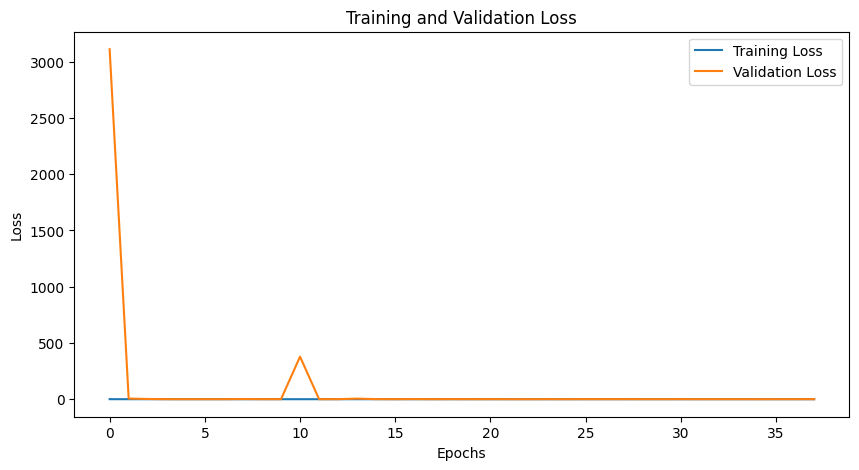

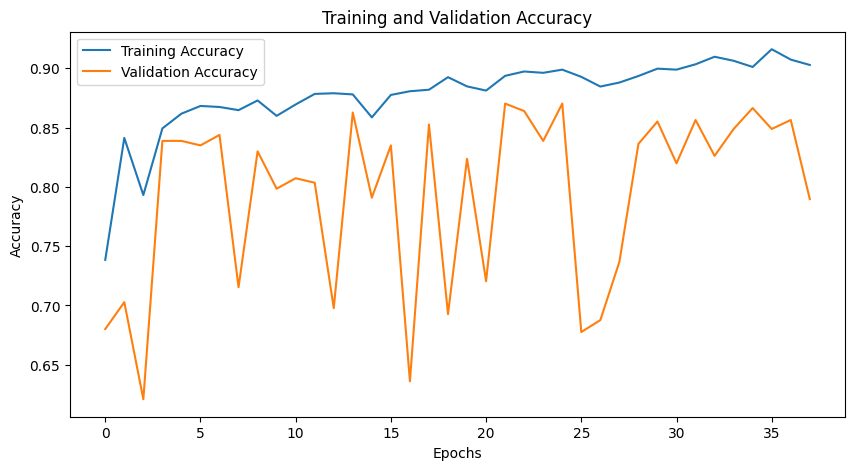

In [ ]:
# Fit the model
epochs = 50
batch_size = 60

history = model_dense.fit_generator(datagen.flow(x_train, y_train_mod, batch_size=batch_size),
                                    epochs=epochs, verbose=1, steps_per_epoch=x_train.shape[0] // batch_size,
                                    callbacks=[learning_rate_reduction,early_stopping,checkpoint], validation_data=(x_validate, y_validate_mod))


# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [ ]:
# Function to plot the confusion matrix with Plotly
import plotly.graph_objects as go
def plot_confusion_matrix(cm, classes, normalize=False):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        colorscale = 'Plasma'
    else:
        colorscale = 'Magma_r'  # Reversed 'Magma' colorscale for non-normalized matrix

    annotations = []
    for i in range(len(classes)):
        for j in range(len(classes)):
            annotations.append(
                {
                    'x': classes[j],
                    'y': classes[i],
                    'text': str(cm[i, j]),
                    'showarrow': False,
                    'font': {'color': 'green' if cm[i, j] > 0.5 else 'black'}
                }
            )

    fig = go.Figure(data=go.Heatmap(
        z=cm,
        x=list(classes),
        y=list(classes),
        colorscale=colorscale,
        colorbar=dict(title='Normalized' if normalize else 'Count'),
        showscale=True,
        hoverinfo='z'
    ))

    fig.update_layout(
        title='Confusion Matrix',
        xaxis=dict(title='Predicted label'),
        yaxis=dict(title='True label'),
        annotations=annotations
    )

    if normalize:
        fig.update_layout(title_text='Normalized Confusion Matrix')
    else:
        fig.update_layout(title_text='Confusion Matrix (Counts)')

    fig.show()

In [ ]:
#Printing classification report
from sklearn.metrics import confusion_matrix, classification_report

classes = range(2)

# Y_true (true labels) and Y_pred_classes (predicted labels) Evaluating performance on test set
Y_pred = model_dense.predict(x_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(y_test_mod, axis=1)

# Compute the confusion matrix
confusion_mtx0 = confusion_matrix(Y_true, Y_pred_classes)

# Plot the confusion matrix with the new colorscale
plot_confusion_matrix(confusion_mtx0, classes=classes, normalize=False)

report = classification_report(Y_true, Y_pred_classes)
print(f"Classification Report for <<DenseNet201>> : ")
print(report)

63/63 [==============================] - 8s 80ms/step


Classification Report for <<DenseNet201>> : 
              precision    recall  f1-score   support

           0       0.91      0.90      0.91      1313
           1       0.81      0.82      0.82       672

    accuracy                           0.88      1985
   macro avg       0.86      0.86      0.86      1985
weighted avg       0.88      0.88      0.88      1985



In [ ]:
df_clean['cell_type'].value_counts()['Melanocytic nevi']/len(df_clean)

0.6682794073178107

## 1/2 and 3/4/5/6

In [ ]:
model_filepath = '/content/drive/MyDrive/Study/Year4/Advanced_DS/Project/ensemble2.hdf5'

checkpoint = ModelCheckpoint(
    filepath=model_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

In [ ]:
def get_6_classes(y_list):
  mod_y = []
  keep_index = []
  for i, cur_y in enumerate(y_list):
    #if not class 0
    if cur_y[0] != 1:
      keep_index.append(i)
      #if class 1 or 2:
      if cur_y[1] == 1 or cur_y[2] == 1:
        mod_y.append([1, 0]) #label if class is 1 or 2
      else:
        mod_y.append([0, 1]) #label if class is 3/4/5/6

  return np.array(mod_y), keep_index

y_train_mod2, train_index= get_6_classes(y_train)
y_validate_mod2, val_index = get_6_classes(y_validate)

In [ ]:
x_train_mod2 = x_train[train_index]
x_validate_mod2 = x_validate[val_index]

<ipython-input-33-19f892257a86>:23: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/50
39/39 [==============================] - ETA: 0s - loss: 0.4702 - accuracy: 0.8076
Epoch 1: val_accuracy improved from -inf to 0.67578, saving model to /content/drive/MyDrive/Study/Year4/Advanced_DS/Project/ensemble2.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



39/39 [==============================] - 99s 614ms/step - loss: 0.4702 - accuracy: 0.8076 - val_loss: 0.9171 - val_accuracy: 0.6758 - lr: 0.0100
Epoch 2/50
39/39 [==============================] - ETA: 0s - loss: 0.3508 - accuracy: 0.8550
Epoch 2: val_accuracy improved from 0.67578 to 0.82422, saving model to /content/drive/MyDrive/Study/Year4/Advanced_DS/Project/ensemble2.hdf5
39/39 [==============================] - 13s 320ms/step - loss: 0.3508 - accuracy: 0.8550 - val_loss: 0.4626 - val_accuracy: 0.8242 - lr: 0.0100
Epoch 3/50
39/39 [==============================] - ETA: 0s - loss: 0.3080 - accuracy: 0.8819
Epoch 3: val_accuracy improved from 0.82422 to 0.83203, saving model to /content/drive/MyDrive/Study/Year4/Advanced_DS/Project/ensemble2.hdf5
39/39 [==============================] - 13s 327ms/step - loss: 0.3080 - accuracy: 0.8819 - val_loss: 0.4155 - val_accuracy: 0.8320 - lr: 0.0100
Epoch 4/50
39/39 [==============================] - ETA: 0s - loss: 0.2886 - accuracy: 0.8832

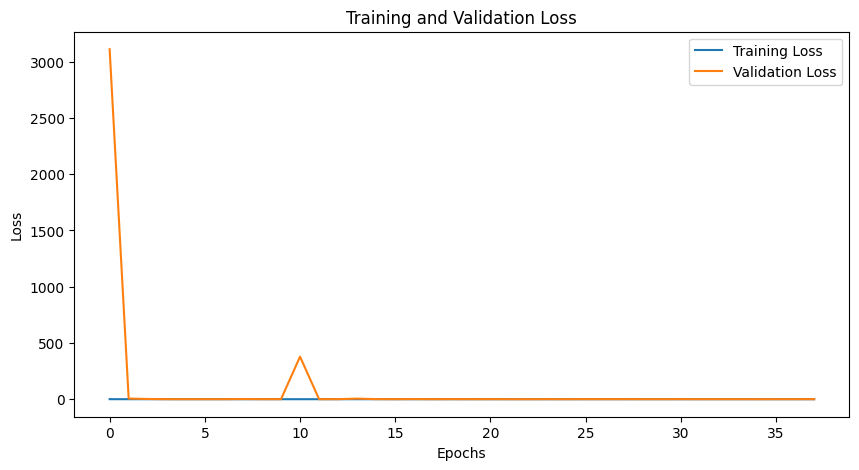

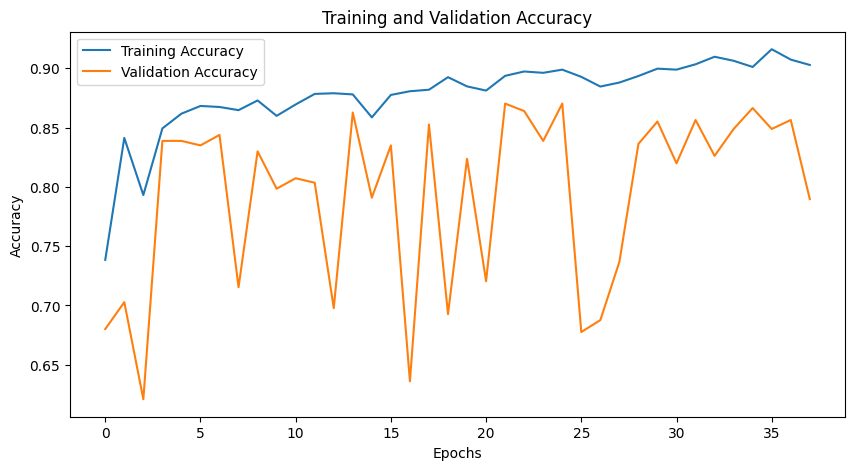

In [ ]:
## train model to distinguish between 1 or 2 and 3/4/5/6

model_dense_2 = Model(inputs=base_model.input, outputs=predictions)

# Learning Rate Scheduler
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,   # Adjust decay_steps
    decay_rate=0.9       # Adjust decay_rate
)
optimizer = Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=False)

model_dense_2.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Fit the model
epochs = 50
batch_size = 60

history_2 = model_dense_2.fit_generator(datagen.flow(x_train_mod2, y_train_mod2, batch_size=batch_size),
                                    epochs=epochs, verbose=1, steps_per_epoch=x_train_mod2.shape[0] // batch_size,
                                    callbacks=[learning_rate_reduction,early_stopping,checkpoint], validation_data=(x_validate_mod2, y_validate_mod2))


# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [ ]:
rest_index = np.where(Y_pred_classes == 1)
x_test_rest = x_test[rest_index]
Y_pred_rest = model_dense.predict(x_test_rest)
Y_pred_classes_rest = np.argmax(Y_pred_rest, axis=1)
len(Y_pred_classes_rest)

22/22 [==============================] - 4s 168ms/step


676

#### final 1 or 2

In [ ]:
model_filepath = '/content/drive/MyDrive/Study/Year4/Advanced_DS/Project/ensemble3.hdf5'

checkpoint = ModelCheckpoint(
    filepath=model_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

In [ ]:
## final of 1 or 2
def get_classes_12(y_list):
  mod_y = []
  keep_index = []
  for i, cur_y in enumerate(y_list):
    # class 1
    if cur_y[1] == 1:
      keep_index.append(i)
      mod_y.append([1, 0])
    # class 2
    if cur_y[2] == 1:
      keep_index.append(i)
      mod_y.append([0, 1])

  return np.array(mod_y), keep_index

y_train_mod12, train_index12= get_classes_12(y_train)
y_validate_mod12, val_index12 = get_classes_12(y_validate)

x_train_mod12 = x_train[train_index12]
x_validate_mod12 = x_validate[val_index12]

<ipython-input-37-aa3ef3cb3bb9>:24: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/50
26/26 [==============================] - ETA: 0s - loss: 0.6868 - accuracy: 0.7109
Epoch 1: val_accuracy improved from -inf to 0.57627, saving model to /content/drive/MyDrive/Study/Year4/Advanced_DS/Project/ensemble3.hdf5
26/26 [==============================] - 93s 642ms/step - loss: 0.6868 - accuracy: 0.7109 - val_loss: 1.0289 - val_accuracy: 0.5763 - lr: 0.0100
Epoch 2/50
26/26 [==============================] - ETA: 0s - loss: 0.4799 - accuracy: 0.7840
Epoch 2: val_accuracy improved from 0.57627 to 0.70621, saving model to /content/drive/MyDrive/Study/Year4/Advanced_DS/Project/ensemble3.hdf5
26/26 [==============================] - 10s 381ms/step - loss: 0.4799 - accuracy: 0.7840 - val_loss: 0.8813 - val_accuracy: 0.7062 - lr: 0.0100
Epoch 3/50
26/26 [==============================] - ETA: 0s - loss: 0.4370 - accuracy: 0.8045
Epoch 3: val_accuracy improved from 0.70621 to 0.78531, saving model to /content/drive/MyDrive/Study/Year4/Advanced_DS/Project/ensemble3.hdf5
26/26

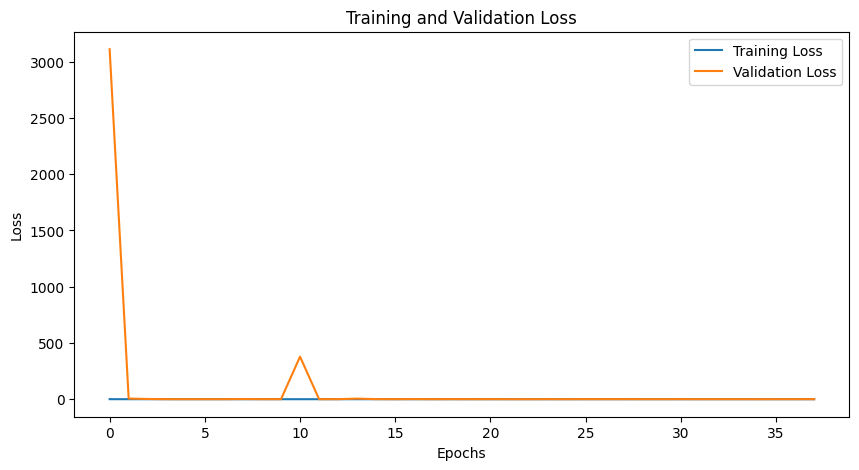

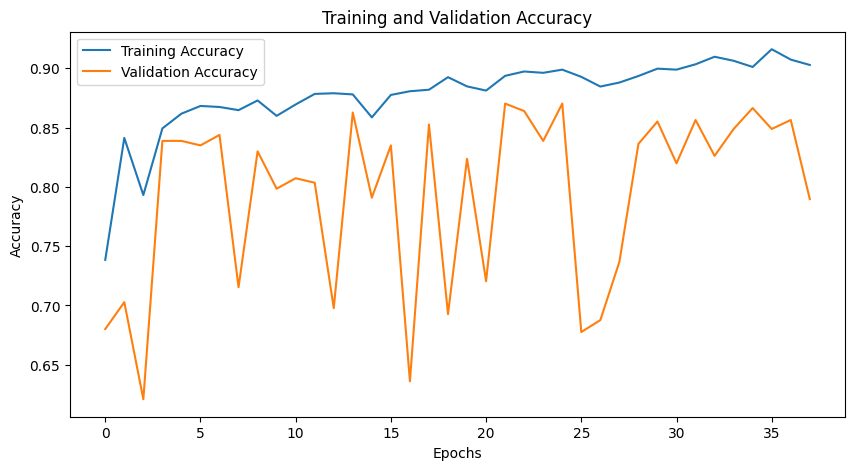

In [ ]:
## use all denseNet
## train model to distinguish between 1 or 2 and 3/4/5/6

model_dense_12 = Model(inputs=base_model.input, outputs=predictions)

# Learning Rate Scheduler
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,   # Adjust decay_steps
    decay_rate=0.9       # Adjust decay_rate
)
optimizer = Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=False)

model_dense_12.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Fit the model
epochs = 50
batch_size = 60

history_12 = model_dense_12.fit_generator(datagen.flow(x_train_mod12, y_train_mod12, batch_size=batch_size),
                                    epochs=epochs, verbose=1, steps_per_epoch=x_train_mod12.shape[0] // batch_size,
                                    callbacks=[learning_rate_reduction,early_stopping,checkpoint], validation_data=(x_validate_mod12, y_validate_mod12))


# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [ ]:
index_12 = np.where(Y_pred_classes_rest == 0)
x_test_12 = x_test_rest[index_12]
Y_pred_12 = model_dense.predict(x_test_12)
Y_pred_classes_12 = np.argmax(Y_pred_12, axis=1)

15/15 [==============================] - 5s 323ms/step


In [ ]:
Y_pred_classes_12 =  np.where(Y_pred_classes_12 == 0, 1, 2)
y_true_12 = np.argmax(y_test[rest_index][index_12],axis=1)

In [ ]:
#Printing classification report
from sklearn.metrics import confusion_matrix, classification_report

classes = range(7)

# Compute the confusion matrix
confusion_mtx12 = confusion_matrix(y_true_12, Y_pred_classes_12, labels=classes)

# Plot the confusion matrix with the new colorscale
plot_confusion_matrix(confusion_mtx12, classes=classes, normalize=False)

report = classification_report(y_true_12, Y_pred_classes_12)
print(f"Classification Report for <<DenseNet201>> : ")
print(report)

Classification Report for <<DenseNet201>> : 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       113
           1       0.57      0.86      0.69       168
           2       0.64      0.89      0.74       161
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        22
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1

    accuracy                           0.60       476
   macro avg       0.17      0.25      0.20       476
weighted avg       0.42      0.60      0.49       476



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



#### 3 or 4 or 5 or 6

In [ ]:
model_filepath = '/content/drive/MyDrive/Study/Year4/Advanced_DS/Project/ensemble4.hdf5'

checkpoint = ModelCheckpoint(
    filepath=model_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

In [ ]:
def get_classes_3456(y_list):
  mod_y = []
  keep_index = []
  for i, cur_y in enumerate(y_list):
    # class 3
    if cur_y[3] == 1:
      keep_index.append(i)
      mod_y.append([1, 0, 0, 0])
    # class 4
    if cur_y[4] == 1:
      keep_index.append(i)
      mod_y.append([0, 1, 0, 0])
    # class 5
    if cur_y[5] == 1:
      keep_index.append(i)
      mod_y.append([0, 0, 1, 0])
    # class 6
    if cur_y[6] == 1:
      keep_index.append(i)
      mod_y.append([0, 0, 0, 1])

  return np.array(mod_y), keep_index

y_train_mod3456, train_index3456= get_classes_3456(y_train)
y_validate_mod3456, val_index3456 = get_classes_3456(y_validate)

x_train_mod3456 = x_train[train_index3456]
x_validate_mod3456 = x_validate[val_index3456]

In [ ]:
# Load the pre-trained DenseNet-201 model (weights pre-trained on ImageNet)
base_model = DenseNet201(weights='imagenet', include_top=False)

# Freeze some layers in the base model
num_layers_to_freeze = 95  # Choose the number of layers you want to freeze
for layer in base_model.layers[:num_layers_to_freeze]:
    layer.trainable = False

# Redefining FC Layer since include_top is set to False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x) #Now predicts 4 classes

# Create the final model
model_dense3456 = Model(inputs=base_model.input, outputs=predictions)

# Learning Rate Scheduler
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,   # Adjust decay_steps
    decay_rate=0.9       # Adjust decay_rate
)
optimizer = Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=False)

model_dense3456.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

<ipython-input-44-466f511a1412>:5: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/50
13/13 [==============================] - ETA: 0s - loss: 4.7658 - accuracy: 0.4455
Epoch 1: val_accuracy improved from -inf to 0.12658, saving model to /content/drive/MyDrive/Study/Year4/Advanced_DS/Project/ensemble4.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



13/13 [==============================] - 89s 1s/step - loss: 4.7658 - accuracy: 0.4455 - val_loss: 1482259111726218372590543568896.0000 - val_accuracy: 0.1266 - lr: 0.0100
Epoch 2/50
13/13 [==============================] - ETA: 0s - loss: 1.0886 - accuracy: 0.5410
Epoch 2: val_accuracy improved from 0.12658 to 0.45570, saving model to /content/drive/MyDrive/Study/Year4/Advanced_DS/Project/ensemble4.hdf5
13/13 [==============================] - 7s 531ms/step - loss: 1.0886 - accuracy: 0.5410 - val_loss: 626366279418118144.0000 - val_accuracy: 0.4557 - lr: 0.0100
Epoch 3/50
13/13 [==============================] - ETA: 0s - loss: 0.9861 - accuracy: 0.5505
Epoch 3: val_accuracy did not improve from 0.45570
13/13 [==============================] - 3s 244ms/step - loss: 0.9861 - accuracy: 0.5505 - val_loss: 303761784832.0000 - val_accuracy: 0.1266 - lr: 0.0100
Epoch 4/50
13/13 [==============================] - ETA: 0s - loss: 0.9764 - accuracy: 0.5545
Epoch 4: val_accuracy did not improve

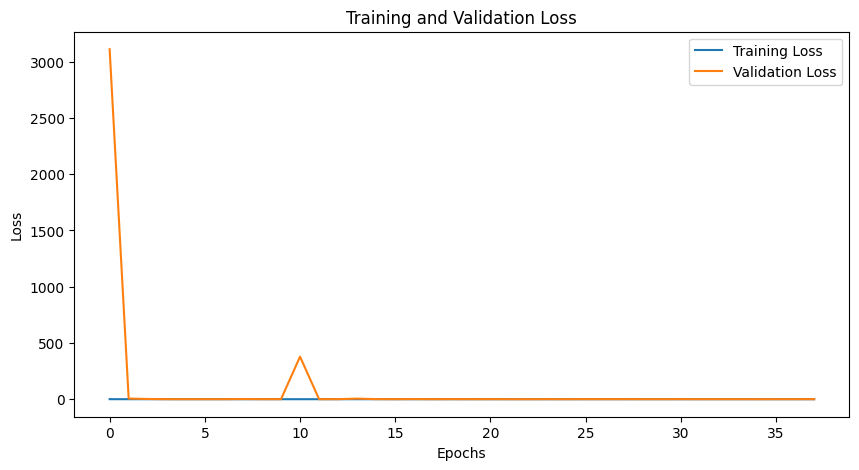

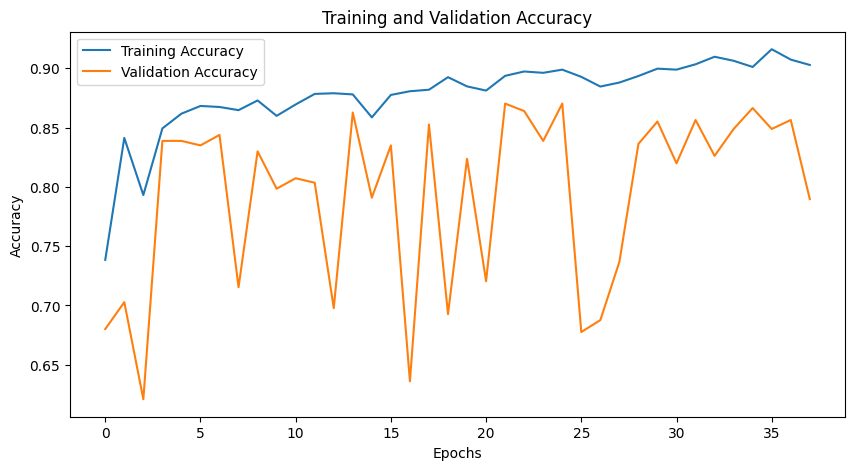

In [ ]:
# Fit the model
epochs = 50
batch_size = 60

history3456 = model_dense3456.fit_generator(datagen.flow(x_train_mod3456, y_train_mod3456, batch_size=batch_size),
                                    epochs=epochs, verbose=1, steps_per_epoch=x_train_mod3456.shape[0] // batch_size,
                                    callbacks=[learning_rate_reduction,early_stopping,checkpoint], validation_data=(x_validate_mod3456, y_validate_mod3456))


# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [ ]:
index_3456 = np.where(Y_pred_classes_rest == 1)
x_test_3456 = x_test_rest[index_3456]
Y_pred_3456 = model_dense3456.predict(x_test_3456)
Y_pred_classes_3456 = np.argmax(Y_pred_3456, axis=1)

7/7 [==============================] - 6s 572ms/step


In [ ]:
Y_pred_classes_3456

array([3, 2, 3, 3, 3, 3, 3, 3, 3, 1, 1, 2, 3, 3, 3, 3, 1, 1, 3, 2, 3, 1,
       1, 2, 3, 1, 3, 2, 1, 3, 1, 3, 3, 0, 3, 3, 1, 3, 3, 3, 1, 1, 1, 3,
       1, 3, 1, 3, 1, 3, 3, 2, 1, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3,
       3, 2, 3, 3, 3, 1, 1, 3, 1, 3, 3, 1, 3, 3, 1, 1, 3, 2, 3, 3, 3, 3,
       1, 3, 1, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 1, 2, 3, 3, 1, 3, 1, 3, 3,
       1, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 1, 3, 1, 1, 3,
       3, 3, 1, 2, 1, 1, 1, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 1, 3, 3,
       3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 1, 1, 3, 3, 3, 3, 1, 3, 2, 3, 3, 1,
       1, 1, 3, 3, 3, 2, 1, 1, 2, 1, 3, 3, 1, 2, 0, 3, 3, 3, 3, 1, 1, 1,
       3, 3])

In [ ]:
Y_pred_classes_3456 = Y_pred_classes_3456 + 3
y_true_3456 = np.argmax(y_test[rest_index][index_3456],axis=1)

In [ ]:
classes = range(7)

# Compute the confusion matrix
confusion_mtx3456 = confusion_matrix(y_true_3456, Y_pred_classes_3456, labels=classes)

# Plot the confusion matrix with the new colorscale
plot_confusion_matrix(confusion_mtx3456, classes=classes, normalize=False)

report = classification_report(y_true_3456, Y_pred_classes_3456)
print(f"Classification Report for <<DenseNet201>> : ")
print(report)

Classification Report for <<DenseNet201>> : 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        25
           3       0.50      0.01      0.02        81
           4       0.34      0.53      0.42        38
           5       0.95      0.90      0.92        20
           6       0.11      1.00      0.19        13

    accuracy                           0.26       200
   macro avg       0.27      0.35      0.22       200
weighted avg       0.37      0.26      0.19       200



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
## get 0 classes
index_0 = np.where(Y_pred_classes == 0)
y_true_0 = np.argmax(y_test[index_0],axis=1)

confusion_mtx0 = confusion_matrix(y_true_0, Y_pred_classes[index_0], labels=classes)

In [ ]:
classes_0 = confusion_mtx0[:, :1]
classes_12 = confusion_mtx12[:,1:3]
classes_3456 = confusion_mtx3456[:,3:]
confusion_mtx = np.concatenate((classes_0, classes_12, classes_3456), axis=1)
confusion_mtx

array([[1187,   73,   40,    1,    1,    0,   11],
       [  60,  144,   24,    0,    0,    1,    9],
       [  36,   18,  143,    0,   10,    0,   15],
       [   9,    4,    6,    1,   27,    0,   53],
       [   6,   11,   11,    0,   20,    0,   18],
       [   3,    1,    0,    0,    0,   18,    2],
       [   8,    1,    0,    0,    0,    0,   13]])

In [ ]:
len(y_true_0)

1309

In [ ]:
plot_confusion_matrix(confusion_mtx, classes=classes, normalize=False)

In [ ]:
def cal_precision_recall (confusion_mtx):
  for i in range (7):
    print('class', i)
    precision = confusion_mtx[i,i] / np.sum(confusion_mtx [:,i])
    recall = confusion_mtx[i,i] / np.sum(confusion_mtx [i])
    print('precision', np.round(precision,2), 'recall', np.round(recall,2))

cal_precision_recall (confusion_mtx)

class 0
precision 0.91 recall 0.9
class 1
precision 0.57 recall 0.61
class 2
precision 0.64 recall 0.64
class 3
precision 0.5 recall 0.01
class 4
precision 0.34 recall 0.3
class 5
precision 0.95 recall 0.75
class 6
precision 0.11 recall 0.59


In [ ]:
total_true = 0
for i in range(7):
  total_true += confusion_mtx[i][i]
accuracy = total_true/len(y_test)
accuracy

0.7687657430730479

## Siamese

In [ ]:
df_clean

lesion_id      image_id     dx dx_type   age     sex localization  \
0      HAM_0000118  ISIC_0027419    bkl   histo  80.0    male        scalp   
1      HAM_0000118  ISIC_0025030    bkl   histo  80.0    male        scalp   
2      HAM_0002730  ISIC_0026769    bkl   histo  80.0    male        scalp   
3      HAM_0002730  ISIC_0025661    bkl   histo  80.0    male        scalp   
4      HAM_0001466  ISIC_0031633    bkl   histo  75.0    male          ear   
...            ...           ...    ...     ...   ...     ...          ...   
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen   
10011  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male      abdomen   
10012  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male      abdomen   
10013  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male         face   
10014  HAM_0003521  ISIC_0032258    mel   histo  70.0  female         back   

                                                    path  \
0      /content/drive/MyDrive/Study/Year4/Advanced_DS...   
1      /content/drive/MyDrive/Study/Year4/Advanced_DS...   
2      /content/drive/MyDrive/Study/Year4/Advanced_DS...   
3      /content/drive/MyDrive/Study/Year4/Advanced_DS...   
4      /content/drive/MyDrive/Study/Year4/Advanced_DS...   
...                                                  ...   
10010  /content/drive/MyDrive/Study/Year4/Advanced_DS...   
10011  /content/drive/MyDrive/Study/Year4/Advanced_DS...   
10012  /content/drive/MyDrive/Study/Year4/Advanced_DS...   
10013  /content/drive/MyDrive/Study/Year4/Advanced_DS...   
10014  /content/drive/MyDrive/Study/Year4/Advanced_DS...   

                            cell_type  cell_type_idx  
0      Benign keratosis-like lesions               2  
1      Benign keratosis-like lesions               2  
2      Benign keratosis-like lesions               2  
3      Benign keratosis-like lesions               2  
4      Benign keratosis-like lesions               2  
...                               ...            ...  
10010               Actinic keratoses              4  
10011               Actinic keratoses              4  
10012               Actinic keratoses              4  
10013               Actinic keratoses              4  
10014                        Melanoma              1  

[9921 rows x 10 columns]

In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from collections import Counter

features=df_clean.drop(columns=['cell_type_idx'],axis=1)
target=df_clean['cell_type_idx']
# Create First Train and Test sets
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=123)
x_train, x_validate, y_train, y_validate = train_test_split(x_train_o, y_train_o, test_size = 0.1,random_state=123)
x_train

lesion_id      image_id   dx    dx_type   age     sex  \
671   HAM_0006993  ISIC_0029206  bkl      histo  65.0  female   
7829  HAM_0006121  ISIC_0034244   nv      histo  20.0  female   
7406  HAM_0006615  ISIC_0033849   nv      histo  45.0    male   
5332  HAM_0003169  ISIC_0028867   nv  follow_up  45.0  female   
103   HAM_0003326  ISIC_0025548  bkl      histo  75.0    male   
...           ...           ...  ...        ...   ...     ...   
7286  HAM_0007350  ISIC_0031202   nv      histo  45.0    male   
439   HAM_0004889  ISIC_0026714  bkl      histo  75.0    male   
3686  HAM_0006836  ISIC_0025678   nv  follow_up  30.0    male   
8320  HAM_0001157  ISIC_0030057   nv      histo  65.0    male   
4245  HAM_0006328  ISIC_0030450   nv  follow_up  75.0  female   

         localization                                               path  \
671              neck  /content/drive/MyDrive/Study/Year4/Advanced_DS...   
7829            chest  /content/drive/MyDrive/Study/Year4/Advanced_DS...   
7406            trunk  /content/drive/MyDrive/Study/Year4/Advanced_DS...   
5332             hand  /content/drive/MyDrive/Study/Year4/Advanced_DS...   
103   lower extremity  /content/drive/MyDrive/Study/Year4/Advanced_DS...   
...               ...                                                ...   
7286             back  /content/drive/MyDrive/Study/Year4/Advanced_DS...   
439   upper extremity  /content/drive/MyDrive/Study/Year4/Advanced_DS...   
3686             back  /content/drive/MyDrive/Study/Year4/Advanced_DS...   
8320  upper extremity  /content/drive/MyDrive/Study/Year4/Advanced_DS...   
4245            trunk  /content/drive/MyDrive/Study/Year4/Advanced_DS...   

                           cell_type  
671   Benign keratosis-like lesions   
7829                Melanocytic nevi  
7406                Melanocytic nevi  
5332                Melanocytic nevi  
103   Benign keratosis-like lesions   
...                              ...  
7286                Melanocytic nevi  
439   Benign keratosis-like lesions   
3686                Melanocytic nevi  
8320                Melanocytic nevi  
4245                Melanocytic nevi  

[7142 rows x 9 columns]

In [ ]:
df_clean['data_set'] = ''

In [ ]:
df_clean['data_set'][x_test_o.index] = 'test'
df_clean['data_set'][x_train.index] = 'train'
df_clean['data_set'][x_validate.index] = 'val'

<ipython-input-35-847c558865e8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['data_set'][x_test_o.index] = 'test'
<ipython-input-35-847c558865e8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['data_set'][x_train.index] = 'train'
<ipython-input-35-847c558865e8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['data_set'][x_validate.index] = 'val'


In [ ]:
df_clean

lesion_id      image_id     dx dx_type   age     sex localization  \
0      HAM_0000118  ISIC_0027419    bkl   histo  80.0    male        scalp   
1      HAM_0000118  ISIC_0025030    bkl   histo  80.0    male        scalp   
2      HAM_0002730  ISIC_0026769    bkl   histo  80.0    male        scalp   
3      HAM_0002730  ISIC_0025661    bkl   histo  80.0    male        scalp   
4      HAM_0001466  ISIC_0031633    bkl   histo  75.0    male          ear   
...            ...           ...    ...     ...   ...     ...          ...   
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen   
10011  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male      abdomen   
10012  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male      abdomen   
10013  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male         face   
10014  HAM_0003521  ISIC_0032258    mel   histo  70.0  female         back   

                                                    path  \
0      /content/drive/MyDrive/Study/Year4/Advanced_DS...   
1      /content/drive/MyDrive/Study/Year4/Advanced_DS...   
2      /content/drive/MyDrive/Study/Year4/Advanced_DS...   
3      /content/drive/MyDrive/Study/Year4/Advanced_DS...   
4      /content/drive/MyDrive/Study/Year4/Advanced_DS...   
...                                                  ...   
10010  /content/drive/MyDrive/Study/Year4/Advanced_DS...   
10011  /content/drive/MyDrive/Study/Year4/Advanced_DS...   
10012  /content/drive/MyDrive/Study/Year4/Advanced_DS...   
10013  /content/drive/MyDrive/Study/Year4/Advanced_DS...   
10014  /content/drive/MyDrive/Study/Year4/Advanced_DS...   

                            cell_type  cell_type_idx data_set  
0      Benign keratosis-like lesions               2    train  
1      Benign keratosis-like lesions               2    train  
2      Benign keratosis-like lesions               2    train  
3      Benign keratosis-like lesions               2     test  
4      Benign keratosis-like lesions               2     test  
...                               ...            ...      ...  
10010               Actinic keratoses              4    train  
10011               Actinic keratoses              4     test  
10012               Actinic keratoses              4    train  
10013               Actinic keratoses              4    train  
10014                        Melanoma              1    train  

[9921 rows x 11 columns]

In [ ]:
import os
import shutil
from glob import glob

def organize_images_from_metadata(metadata, base_skin_dir, input_folders, output_folder):
    # Read metadata table
    # metadata = pd.read_csv(metadata_file)

    for input_folder in input_folders:
        # Get a list of all image files in the current input folder
        image_files = glob(os.path.join(base_skin_dir, input_folder, '*.jpg'))

        # Organize images into folders based on their class from the metadata table
        for index, row in metadata.iterrows():
            image_name = row['image_id']
            class_label = row['dx']

            # Check if the image exists in the current input folder
            image_path = row['path']
            #print(image_path)
            if os.path.exists(image_path):
                #print(image_path)
                # Create a folder for the class if it doesn't exist
                class_folder = os.path.join(output_folder, class_label)
                os.makedirs(class_folder, exist_ok=True)

                # Copy the image file to the class folder
                shutil.copy(image_path, os.path.join(class_folder, image_name + '.jpg'))

In [ ]:
base_skin_dir = '/content/drive/MyDrive/Study/Year4/Advanced_DS/Project'
input_folders = ['HAM10000_images_part_1','HAM10000_images_part_2']
#metadata_file = '/content/drive/MyDrive/Study/Year4/Advanced_DS/Project/HAM10000_metadata.csv'
output_folder = base_skin_dir + '/siamese'

organize_images_from_metadata(df_clean, base_skin_dir, input_folders, output_folder)

KeyboardInterrupt: ignored

In [ ]:
import os
import shutil
import pandas as pd

def copy_images_with_label(source_folder1, source_folder2, destination_folder, dataframe, label_column='data_set'):
    # Create train, validate, and test folders
    train_folder = os.path.join(destination_folder, 'train')
    val_folder = os.path.join(destination_folder, 'validate')
    test_folder = os.path.join(destination_folder, 'test')

    for folder in [train_folder, val_folder, test_folder]:
        os.makedirs(folder, exist_ok=True)

    # Copy images to train folder
    copy_images_to_folder(source_folder1, os.path.join(train_folder, 'class1'), dataframe[(dataframe[label_column] == 'train') & (dataframe['dx'] == 'mel')])
    copy_images_to_folder(source_folder2, os.path.join(train_folder, 'class2'), dataframe[(dataframe[label_column] == 'train') & (dataframe['dx'] == 'bkl')])

    # Copy images to validate folder
    copy_images_to_folder(source_folder1, os.path.join(val_folder, 'class1'), dataframe[(dataframe[label_column] == 'val') & (dataframe['dx'] == 'mel')])
    copy_images_to_folder(source_folder2, os.path.join(val_folder, 'class2'), dataframe[(dataframe[label_column] == 'val') & (dataframe['dx'] == 'bkl')])

    # Copy images to test folder
    copy_images_to_folder(source_folder1, os.path.join(test_folder, 'class1'), dataframe[(dataframe[label_column] == 'test') & (dataframe['dx'] == 'mel')])
    copy_images_to_folder(source_folder2, os.path.join(test_folder, 'class2'), dataframe[(dataframe[label_column] == 'test') & (dataframe['dx'] == 'bkl')])

def copy_images_to_folder(source_folder, destination_folder, dataframe):
    for index, row in dataframe.iterrows():
        source_path = os.path.join(source_folder, row['image_id']+'.jpg')
        destination_path = os.path.join(destination_folder, row['dx'], row['image_id']+'.jpg')
        os.makedirs(os.path.dirname(destination_path), exist_ok=True)
        shutil.copy2(source_path, destination_path)

# Example usage:
class1_2folder = '/content/drive/MyDrive/Study/Year4/Advanced_DS/Project/siamese/class1_2/'
source_folder1 = class1_2folder + 'mel'
source_folder2 = class1_2folder + 'bkl'
destination_folder = '/content/drive/MyDrive/Study/Year4/Advanced_DS/Project/class1_2/'

# Assume you have a DataFrame named 'df' with columns 'image_id', 'class', and 'data_set' (train, validate, test)
copy_images_with_label(source_folder1, source_folder2, destination_folder, df_clean, label_column='data_set')


In [ ]:
import os
import shutil
import pandas as pd
def add_extension_to_images(folder_path):
    for filename in os.listdir(folder_path):
        if filename.endswith(tuple(['.jpg', '.jpeg', '.png'])):
            continue  # Skip files that already have an extension
        old_path = os.path.join(folder_path, filename)
        new_path = os.path.join(folder_path, f"{filename}.jpg")
        os.rename(old_path, new_path)
        print(f"Renamed: {old_path} -> {new_path}")

# Example usage:
folder_path = "/content/drive/MyDrive/Study/Year4/Advanced_DS/Project/class1_2/"
add_extension_to_images(folder_path+'train/bkl')
add_extension_to_images(folder_path+'train/mel')
add_extension_to_images(folder_path+'validate/bkl')
add_extension_to_images(folder_path+'validate/mel')
add_extension_to_images(folder_path+'test/bkl')
add_extension_to_images(folder_path+'test/mel')

Renamed: /content/drive/MyDrive/Study/Year4/Advanced_DS/Project/class1_2/validate/bkl/ISIC_0034280 -> /content/drive/MyDrive/Study/Year4/Advanced_DS/Project/class1_2/validate/bkl/ISIC_0034280.jpg
Renamed: /content/drive/MyDrive/Study/Year4/Advanced_DS/Project/class1_2/validate/bkl/ISIC_0032843 -> /content/drive/MyDrive/Study/Year4/Advanced_DS/Project/class1_2/validate/bkl/ISIC_0032843.jpg
Renamed: /content/drive/MyDrive/Study/Year4/Advanced_DS/Project/class1_2/validate/bkl/ISIC_0026511 -> /content/drive/MyDrive/Study/Year4/Advanced_DS/Project/class1_2/validate/bkl/ISIC_0026511.jpg
Renamed: /content/drive/MyDrive/Study/Year4/Advanced_DS/Project/class1_2/validate/bkl/ISIC_0026790 -> /content/drive/MyDrive/Study/Year4/Advanced_DS/Project/class1_2/validate/bkl/ISIC_0026790.jpg
Renamed: /content/drive/MyDrive/Study/Year4/Advanced_DS/Project/class1_2/validate/bkl/ISIC_0027142 -> /content/drive/MyDrive/Study/Year4/Advanced_DS/Project/class1_2/validate/bkl/ISIC_0027142.jpg
Renamed: /content/dr

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

# Creating some helper functions
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})

    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

class SiameseNetworkDataset(Dataset):
    def __init__(self,imageFolderDataset,transform=None):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform

    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)

        #We need to approximately 50% of images to be in the same class
        should_get_same_class = random.randint(0,1)
        if should_get_same_class:
            while True:
                #Look untill the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:

            while True:
                #Look untill a different class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] != img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        #img0 = img0.convert("L")
        #img1 = img1.convert("L")

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))

    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [ ]:
train_folder = '/content/drive/MyDrive/Study/Year4/Advanced_DS/Project/class1_2/train'

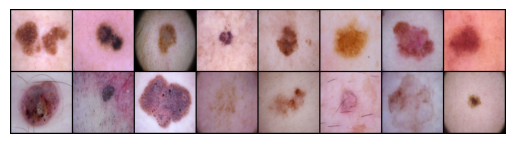

[0. 1. 0. 0. 0. 1. 1. 0.]


In [ ]:
base_skin_dir = '/content/drive/MyDrive/Study/Year4/Advanced_DS/Project'
input_folders = ['HAM10000_images_part_1','HAM10000_images_part_2']
#metadata_file = '/content/drive/MyDrive/Study/Year4/Advanced_DS/Project/HAM10000_metadata.csv'
output_folder = base_skin_dir + '/siamese'
# Load the training dataset
folder_dataset = datasets.ImageFolder(train_folder)

# Resize the images and transform to tensors
transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor()
                                    ])

# Initialize the network
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transformation)

# Create a simple dataloader just for simple visualization
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=8)

# Extract one batch
example_batch = next(iter(vis_dataloader))

# Example batch is a list containing 2x8 images, indexes 0 and 1, an also the label
# If the label is 1, it means that it is not the same person, label is 0, same person in both images
concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

In [ ]:
#create the Siamese Neural Network
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11,stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3,stride=1),
            nn.ReLU(inplace=True)
        )

        # Setting up the Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(inplace=True),

            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),

            nn.Linear(256,2)
        )

    def forward_once(self, x):
        # This function will be called for both images
        # It's output is used to determine the similiarity
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

In [ ]:
# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidian distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

# Load the training dataset
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=64)

net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0005 )

Epoch number 0
 Current loss 1.9349733591079712

Epoch number 0
 Current loss 1.208154559135437

Epoch number 0
 Current loss 1.3870716094970703

Epoch number 1
 Current loss 1.4174526929855347

Epoch number 1
 Current loss 1.1911288499832153

Epoch number 1
 Current loss 1.0535821914672852

Epoch number 2
 Current loss 1.0151066780090332

Epoch number 2
 Current loss 1.1195502281188965

Epoch number 2
 Current loss 1.135850429534912

Epoch number 3
 Current loss 1.3244372606277466

Epoch number 3
 Current loss 0.9341248273849487

Epoch number 3
 Current loss 1.1699035167694092

Epoch number 4
 Current loss 1.0055776834487915

Epoch number 4
 Current loss 1.0722644329071045

Epoch number 4
 Current loss 1.2134047746658325

Epoch number 5
 Current loss 1.1469371318817139

Epoch number 5
 Current loss 1.0108532905578613

Epoch number 5
 Current loss 0.9083585739135742

Epoch number 6
 Current loss 1.1718783378601074

Epoch number 6
 Current loss 1.0759925842285156

Epoch number 6
 Curren

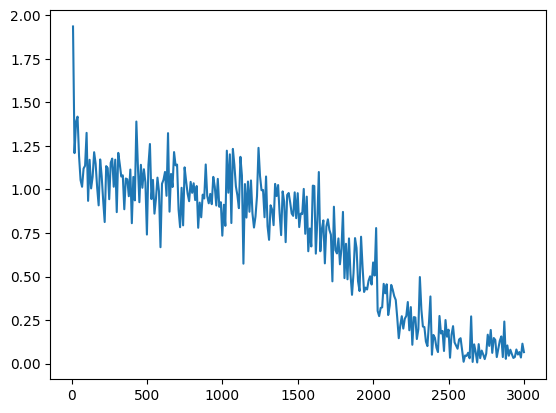

In [ ]:
counter = []
loss_history = []
iteration_number= 0

# Iterate throught the epochs
for epoch in range(100):

    # Iterate over batches
    for i, (img0, img1, label) in enumerate(train_dataloader, 0):

        # Send the images and labels to CUDA
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()

        # Zero the gradients
        optimizer.zero_grad()

        # Pass in the two images into the network and obtain two outputs
        output1, output2 = net(img0, img1)

        # Pass the outputs of the networks and label into the loss function
        loss_contrastive = criterion(output1, output2, label)

        # Calculate the backpropagation
        loss_contrastive.backward()

        # Optimize
        optimizer.step()

        # Every 10 batches print out the loss
        if i % 10 == 0 :
            print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

show_plot(counter, loss_history)

In [ ]:
# Specify the path where you want to save the model
model_path = '/content/drive/MyDrive/Study/Year4/Advanced_DS/Project/siamcheckpoint_12.pth'

checkpoint = {
    'model_state_dict': net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'criterion': criterion,
}

torch.save(checkpoint, model_path)

In [ ]:
# Load the saved checkpoint
model_path = '/content/drive/MyDrive/Study/Year4/Advanced_DS/Project/siamcheckpoint_12.pth'
loaded_checkpoint = torch.load(model_path)

# Create a new instance of your model
loaded_model = SiameseNetwork().cuda()

# Load the model's state dictionary and optimizer state dictionary
loaded_model.load_state_dict(loaded_checkpoint['model_state_dict'])
# Note: If you want to continue training, you can also load the optimizer state
# optimizer.load_state_dict(loaded_checkpoint['optimizer_state_dict'])

# Access other information from the checkpoint
#loaded_epoch = loaded_checkpoint['epoch']
#loaded_loss = loaded_checkpoint['loss']

# Now, 'loaded_model' contains the loaded model parameters
net = loaded_model

In [ ]:
val_folder = '/content/drive/MyDrive/Study/Year4/Advanced_DS/Project/class1_2/validate'

In [ ]:
# Locate the test dataset and load it into the SiameseNetworkDataset
folder_dataset_test = datasets.ImageFolder(val_folder)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transformation)
test_dataloader = DataLoader(siamese_dataset, num_workers=2, batch_size=1, shuffle=True)

scores = []
dataiter = iter(test_dataloader)
for img in dataiter:
  x0, _, _ = img
  # Iterate over other images images and test them with the first image (x0)
  dataiter2 = iter(test_dataloader)
  for i in dataiter2:
      _, x1, label2 = i
      # Concatenate the two images together
      concatenated = torch.cat((x0, x1), 0)

      output1, output2 = net(x0.cuda(), x1.cuda())
      euclidean_distance = F.pairwise_distance(output1, output2)
      #imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')
      scores.append([label2,euclidean_distance.item() ])

import matplotlib.pyplot as plt
import numpy as np

# Convert label_score tensor data into numpy arrays for labels and scores
labels = np.array([item[0].numpy()[0][0] for item in scores])
scores = np.array([item[1] for item in scores])

matches = scores[labels == 0]
non_matches = scores[labels == 1]

thresholds = np.linspace(start=min(matches.min(), non_matches.min()),
                             stop=max(matches.max(), non_matches.max()), num=1000)
accuracies = []
for thresh in thresholds:

    tp = (matches < thresh).sum()
    tn = (matches >= thresh).sum()
    accuracies.append((tp + tn)/len(scores))

best_threshold_index = np.argmax(accuracies)
print('Best threshold by accuracies', thresholds[best_threshold_index])


f1_scores = []
for thresh in thresholds:
    tp = (matches < thresh).sum()
    fp = (non_matches < thresh).sum()
    fn = (matches >= thresh).sum()
    tn = (non_matches >= thresh).sum()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    f1_scores.append(f1_score)

best_threshold_index = np.argmax(f1_scores)
print('Best threshold by f1', thresholds[best_threshold_index])

Best threshold by accuracies 1.4142135569272796e-06
Best threshold by f1 2.203003324214484


In [ ]:
print('Best accuracy of validation set',np.max(accuracies))
print('Best f1 of validation set',np.max(f1_scores))

Best accuracy of validation set 0.5034951642248396
Best f1 of validation set 0.6698377643761149


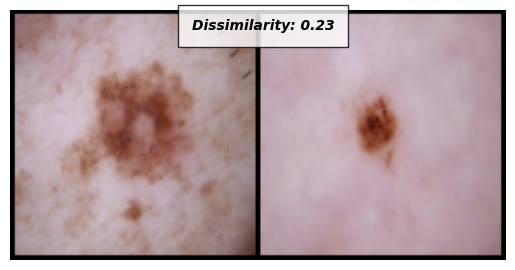

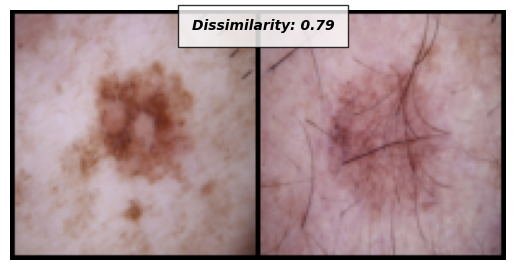

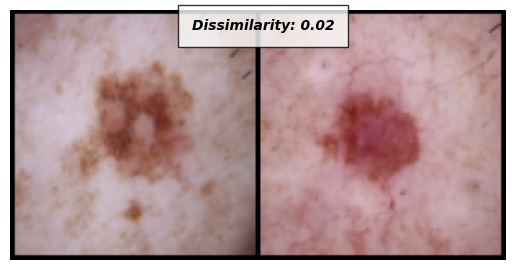

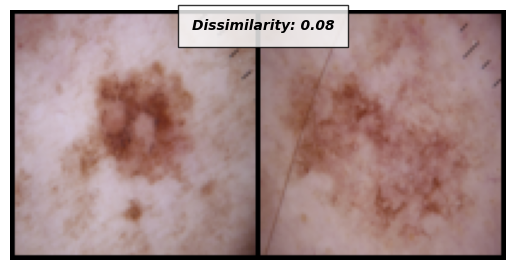

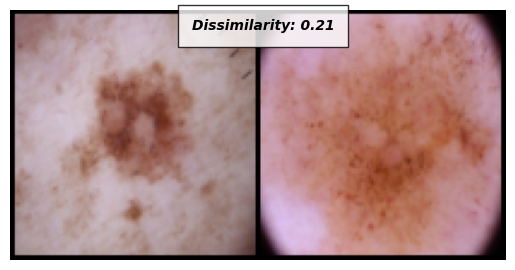

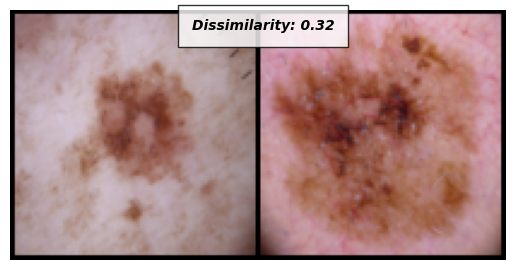

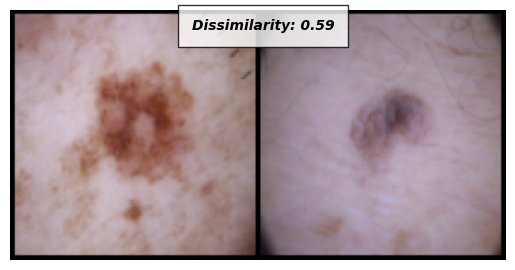

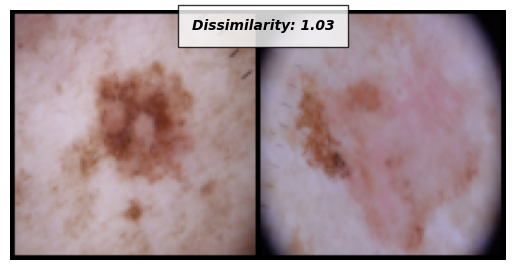

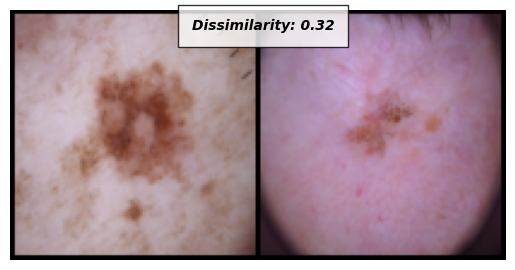

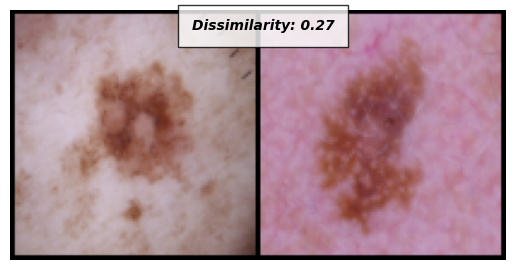

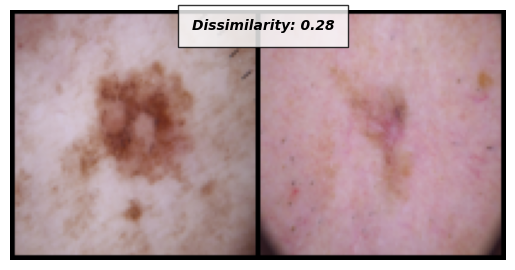

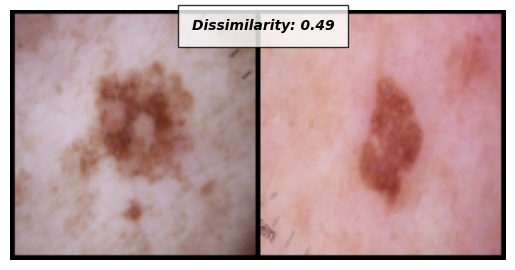

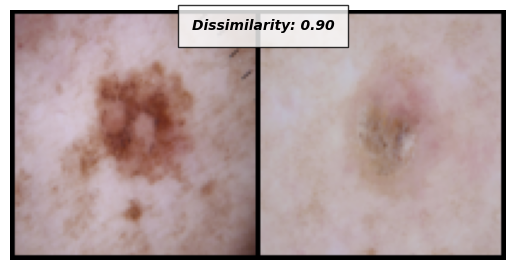

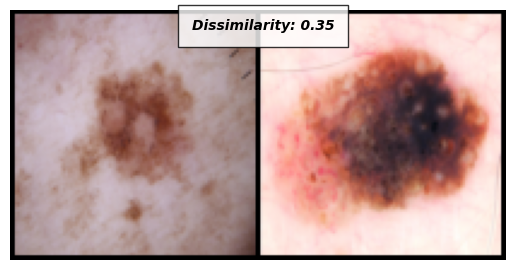

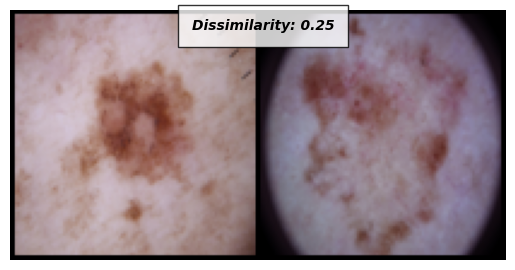

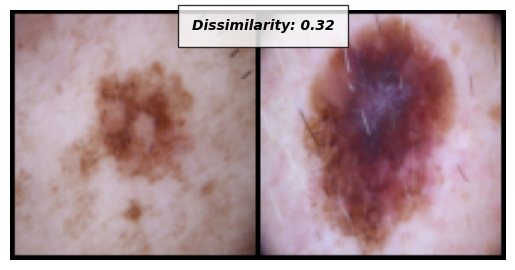

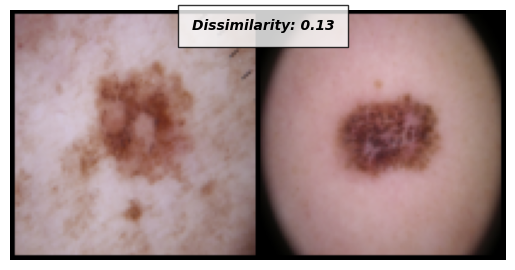

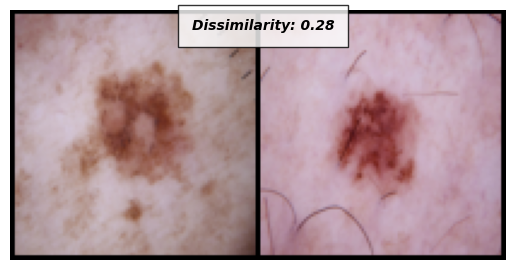

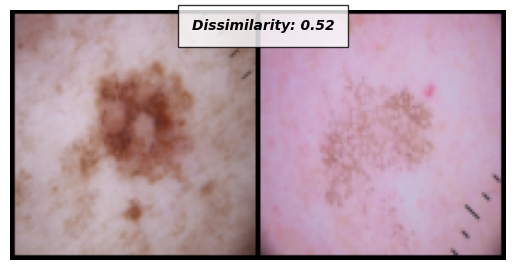

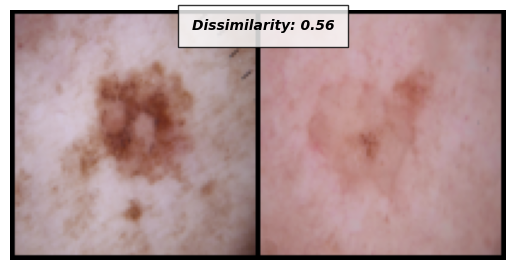

In [ ]:
# Locate the test dataset and load it into the SiameseNetworkDataset
# only get class 1 and 2
#Lesion Dictionary categorical codes
lesion_code_dict = {
    'nv': 0,
    'mel': 1,
    'bkl': 2,
    'bcc': 3,
    'akiec': 4,
    'vasc': 5,
    'df': 6}

class1_2_folder = '/content/drive/MyDrive/Study/Year4/Advanced_DS/Project/'

folder_dataset_test = datasets.ImageFolder(class1_2folder)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transformation)
test_dataloader = DataLoader(siamese_dataset, num_workers=2, batch_size=1, shuffle=True)

# Grab one image that we are going to test
scores = []
dataiter = iter(test_dataloader)
for img in dataiter:
  x0, _, _ = img
  # Iterate over other images images and test them with the first image (x0)
  dataiter2 = iter(test_dataloader)
  for i in dataiter2:
      _, x1, label2 = i
      # Concatenate the two images together
      concatenated = torch.cat((x0, x1), 0)

      output1, output2 = net(x0.cuda(), x1.cuda())
      euclidean_distance = F.pairwise_distance(output1, output2)
      #imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')
      scores.append([label2,euclidean_distance.item() ])